# Header

In [1]:
from utils import *
import forestplot as fp

from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score,roc_curve

from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
from IPython.display import display, HTML
from statannotations.Annotator import Annotator

In [2]:
sns.set(font_scale=1.2)
sns.set_style('white')

plt.rcParams['figure.dpi'] = 300

In [3]:
bone_name_keys2 = {
    '1A1':'Tibia',
    '1A2':'Fibula',
    '1A3':'Radius',
    '1A4':'Ulna',
    '1A5':'All'
}

varname_keys = {
    
    'Neck_T':'aBMD:Femur neck',
    'L1_L4_T':'aBMD:Lumbar spine',
    'Total_T':'aBMD:Total hip',
    'BV/TV':'BV/TV',
    'Ct_Ar':'Ct.Ar','Ct_Pm':'Ct.Pm', 'Ct_Po':'Ct.Po', 'Ct_Th':'Ct.Th','Ct_vBMD':'Ct.vBMD',
    'Tb_Ar':'Tb.Ar', 'Tb_N':'Tb.N', 'Tb_Sp':'Tb.Sp', 'Tb_Th':'Tb.Th', 'Tb_vBMD':'Tb.vBMD', 
    'Tt_Ar':'Tt.Ar','Tt_vBMD':'Tt.vBMD', 
    'age':'Age', 'height':'Height', 'weight':'Weight','sex':'Sex'
}

pqctparams_keys = {
    'tibia_fibula':['TIBIA_Tt_Ar', 'TIBIA_Tt_vBMD', 'TIBIA_Tb_Ar', 'TIBIA_Tb_vBMD', 'TIBIA_BV_TV', 'TIBIA_Tb_N', 'TIBIA_Tb_Th', 'TIBIA_Tb_Sp', 'TIBIA_Ct_Ar', 'TIBIA_Ct_vBMD', 'TIBIA_Ct_Pm', 'TIBIA_Ct_Po', 'TIBIA_Ct_Th'],
    'raidus_ulna':['RADIUS_Tt_Ar','RADIUS_Tt_vBMD','RADIUS_Tb_Ar','RADIUS_Tb_vBMD','RADIUS_BV_TV','RADIUS_Tb_N','RADIUS_Tb_Th','RADIUS_Tb_Sp','RADIUS_Ct_Ar','RADIUS_Ct_vBMD','RADIUS_Ct_Pm','RADIUS_Ct_Po','RADIUS_Ct_Th'],
    'four_bones':['RADIUS_Tt_Ar','RADIUS_Tt_vBMD','RADIUS_Tb_Ar','RADIUS_Tb_vBMD','RADIUS_BV_TV','RADIUS_Tb_N','RADIUS_Tb_Th','RADIUS_Tb_Sp','RADIUS_Ct_Ar','RADIUS_Ct_vBMD','RADIUS_Ct_Pm','RADIUS_Ct_Po','RADIUS_Ct_Th',                    
                'TIBIA_Tt_Ar', 'TIBIA_Tt_vBMD', 'TIBIA_Tb_Ar', 'TIBIA_Tb_vBMD', 'TIBIA_BV_TV', 'TIBIA_Tb_N', 'TIBIA_Tb_Th', 'TIBIA_Tb_Sp', 'TIBIA_Ct_Ar', 'TIBIA_Ct_vBMD', 'TIBIA_Ct_Pm', 'TIBIA_Ct_Po', 'TIBIA_Ct_Th']
}

pqctparams = ['RADIUS_Tt_Ar', 'RADIUS_Tt_vBMD', 'RADIUS_Tb_Ar', 'RADIUS_Tb_vBMD', 'RADIUS_BV/TV', 'RADIUS_Tb_N', 'RADIUS_Tb_Th', 'RADIUS_Tb_Sp', 'RADIUS_Ct_Ar', 'RADIUS_Ct_vBMD', 'RADIUS_Ct_Pm', 'RADIUS_Ct_Po', 'RADIUS_Ct_Th', 'TIBIA_Tt_Ar', 'TIBIA_Tt_vBMD', 'TIBIA_Tb_Ar', 'TIBIA_Tb_vBMD', 'TIBIA_BV/TV', 'TIBIA_Tb_N', 'TIBIA_Tb_Th', 'TIBIA_Tb_Sp', 'TIBIA_Ct_Ar', 'TIBIA_Ct_vBMD', 'TIBIA_Ct_Pm', 'TIBIA_Ct_Po', 'TIBIA_Ct_Th']

bmdparams_keys = {'mid':'L1_L4_T',
                  'neck':'Neck_T',
                  'total':'Total_T'}

bmd_params = list(bmdparams_keys.values())

In [4]:
meta = pd.read_csv('../data/meta/chivos_fragfrax_final.csv', index_col=0) #[['ptid','label','sex','age','height','weight']]

# meta['age'] = meta['age'] / 100
meta['height'] = meta['height'] / 100 # original in cm
# meta['weight'] = meta['weight'] / 10 # original in kg

# for name in ['RADIUS_Tt_Ar', 'RADIUS_Tt_vBMD', 'RADIUS_Tb_Ar', 'RADIUS_Tb_vBMD', 'RADIUS_Ct_Ar','RADIUS_Ct_vBMD','RADIUS_Ct_Pm',  'TIBIA_Tt_Ar', 'TIBIA_Tt_vBMD', 'TIBIA_Tb_Ar', 'TIBIA_Tb_vBMD', 'TIBIA_Ct_Ar','TIBIA_Ct_vBMD','TIBIA_Ct_Pm']:
#     meta[name] /= 100
# for name in ['RADIUS_Ct_Po', 'TIBIA_Ct_Po']:
#     meta[name] *= 100

# for name in ['RADIUS_BV/TV','TIBIA_BV/TV']:
#     meta[name] *= 100

meta.columns = [x.replace('BV/TV', 'BV_TV') for x in meta.columns]

print(meta.shape)
meta.head(3)

(216, 46)


ptid  label  sex  age  height  weight  RADIUS_Tt_Ar  RADIUS_Tt_vBMD  \
0  1472      5    1   54   1.540    59.0         228.2           269.6   
1  1484      5    1   58   1.603    49.0         223.2           248.6   
2  1473      0    1   54   1.450    54.0         170.2           362.1   

   RADIUS_Tb_Ar  RADIUS_Tb_vBMD  ...  L1_L4_T  Neck_T  Total_T  \
0         172.2            40.9  ...     -1.3    -2.8     -2.3   
1         177.8            86.7  ...     -3.4    -1.9     -1.3   
2         121.2           129.8  ...     -2.2    -0.2     -0.4   

   FractureHistory  Source  ChivosID  Label_fracture  Label_VF  \
0                0  Chivos      2001               0         0   
1                0  Chivos      2001               0         0   
2                0  Chivos      2002               0         0   

   fragility_fracture  Label_OP  
0                   0         1  
1                   0         1  
2                   0         0  

[3 rows x 46 columns]

# Performance

## Internal test set

### Performance

In [5]:
history = {}

k = 6
dim = 128
seed = 2023
splits=KFold(n_splits=k,shuffle=True,random_state=seed)

label_name = 'fragility_fracture'

#----------------------------------------------------------------------------------------------
meta = pd.read_csv('../data/meta/chivos_fragfrax_final.csv', index_col=0) #[['ptid','label','sex','age','height','weight']]
meta['height'] = meta['height'] / 100 # original in cm
meta.columns = [x.replace('BV/TV', 'BV_TV') for x in meta.columns]

#----------------------------------------------------------------------------------------------
for trial_name in ['1A1','1A2','1A3','1A4','1A5']:
        
        history[f'{trial_name}'] = {}
        pqct_params = pqctparams_keys['tibia_fibula'] if trial_name in ['1A1','1A2', '2A1','2A2'] \
                else pqctparams_keys['raidus_ulna'] if trial_name in ['1A3','1A4', '2A3','2A4'] \
                else pqctparams_keys['four_bones']
        
        
        col_keys = {
#         'Basic': ['age','height','weight'],

        'Basic+BMD':['age','height','weight']+bmd_params,
            
        'Basic+PQCT':['age','height','weight']+pqct_params,#+bmd_params+pqct_params,  
            
        'Basic+PQCT-DL':['age','height','weight']+[f'v{i}' for i in range(128)],#+bmd_params+[f'v{i}' for i in range(128)],
            
#         'Basic+PQCT+PQCT-DL':['age','height','weight']+bmd_params+pqct_params+[f'v{i}' for i in range(128)]  
        }

        for fold in range(1,7):

            history[f'{trial_name}'][fold] = {}


            indices_dict = pkl.load(open(f'../data/meta/indices_{trial_name}.pkl', 'rb'))
            meta_recoded = indices_dict['recoded_meta']
            test_indices = indices_dict['test_indices']
            train_indices = indices_dict[f'train_indices_noaug_fold{fold}']

            df = pd.read_csv(f'../data/embeds/{trial_name}_fold{fold}_dim{dim}.csv', index_col=0)
            df['ptid'] = df['ptid'].astype(int)
            df = pd.merge(df, meta[['ptid','age','height','weight']+pqct_params+bmd_params], on='ptid')
            assert_frame_equal(df[['ptid']], meta_recoded[['ptid']])

            indices_dict[f'embeddings_{fold}'] = df

            for method in ['logistic','svm','rf']:

                history[f'{trial_name}'][fold][method] = {}

                for sel_col in col_keys.keys(): # dl|conv_plus: embeds(dim|26) + age+gender

                    sel_colnames = col_keys[sel_col]
                    df_train = df.iloc[train_indices,:]

                    train_X = df_train.loc[:,sel_colnames].values # [N, 256]
                    train_Y = df_train[label_name].values

                    if method=='logistic':
                        clf = LogisticRegression(random_state=seed, multi_class='multinomial').fit(train_X, train_Y) # shuffle data by random_state
                    elif method=='svm':
                        clf = make_pipeline(StandardScaler(),SVC(random_state=seed, probability=True))
                    elif method=='rf':
                        clf = RandomForestClassifier(random_state=seed)

                    clf.fit(train_X, train_Y)

                    df_test = df.iloc[test_indices,:]

                    test_X = df_test.loc[:,sel_colnames].values
                    test_Y = df_test[label_name].values
                    pred_labels = clf.predict(test_X)
                    pred_probs = clf.predict_proba(test_X)

                    loss = log_loss(test_Y, pred_probs)
                    auc = roc_auc_score(test_Y, pred_probs[:,1], labels=[0,1]) # 2 class
                    acc = accuracy_score(test_Y, pred_labels)  
                    f1 = f1_score(test_Y, pred_labels, labels=[0,1])
                    precision = precision_score(test_Y, pred_labels)  # For binary classification, labels parameter is not necessary
                    recall = recall_score(test_Y, pred_labels)  # For binary classification, labels parameter is not necessary
                    fpr, tpr, thresholds = roc_curve(test_Y, pred_probs[:, 1])
                    J = tpr - fpr
                    optimal_idx = np.argmax(J)
                    optimal_threshold = thresholds[optimal_idx]

                    history[f'{trial_name}'][fold][method][sel_col] = {'auc':auc,'acc':acc,'f1':f1,
                                                                       'precision':precision,
                                                                       'recall':recall,
                                                                       'fpr':fpr,'tpr':tpr,'thresholds':thresholds,'optimal_threshold':optimal_threshold}

history

{'1A1': {1: {'logistic': {'Basic+BMD': {'auc': 0.7375,
     'acc': 0.8095238095238095,
     'f1': 0.5,
     'precision': 0.6666666666666666,
     'recall': 0.4,
     'fpr': array([0.    , 0.    , 0.    , 0.375 , 0.375 , 0.5625, 0.5625, 1.    ]),
     'tpr': array([0. , 0.2, 0.4, 0.4, 0.8, 0.8, 1. , 1. ]),
     'thresholds': array([1.64103205, 0.64103205, 0.61572283, 0.39373516, 0.31858446,
            0.23963836, 0.21232053, 0.06274656]),
     'optimal_threshold': 0.21232053065901632},
    'Basic+PQCT': {'auc': 0.75,
     'acc': 0.8095238095238095,
     'f1': 0.6,
     'precision': 0.6,
     'recall': 0.6,
     'fpr': array([0.    , 0.0625, 0.0625, 0.125 , 0.125 , 0.375 , 0.375 , 0.5625,
            0.5625, 1.    ]),
     'tpr': array([0. , 0. , 0.2, 0.2, 0.6, 0.6, 0.8, 0.8, 1. , 1. ]),
     'thresholds': array([1.61157538, 0.61157538, 0.59563178, 0.57123488, 0.53739341,
            0.29200967, 0.26614356, 0.22311407, 0.21131185, 0.05017539]),
     'optimal_threshold': 0.53739341357157

In [6]:
metrics_df = pd.json_normalize([history])

dat = pd.DataFrame()

dat['trial'] = [x.split('.')[0].split('_')[0] for x in metrics_df.columns]
dat['fold'] = [x.split('.')[1] for x in metrics_df.columns]
dat['fusionMethod'] = [x.split('.')[2] for x in metrics_df.columns]
dat['model'] = [x.split('.')[3] for x in metrics_df.columns]
dat['metric'] = [x.split('.')[4] for x in metrics_df.columns]
dat['score'] = metrics_df.values[0]

dat['bone'] = ['tibia' if x in ['1A1','2A1'] \
               else 'fibula' if x in ['1A2','2A2'] \
               else 'radius' if x in ['1A3','2A3'] \
               else 'ulna' if x in ['1A4','2A4'] \
               else 'all' if x in ['1A5','2A5']
               else None for x in dat['trial']]

model_new_list = []
for i,row in dat.iterrows():
    
    model = row['model']; bone = row['bone']
    if model == 'Basic+PQCT-DL':
        model_new = 'Basic+PQCT-DL(large bone)' if bone in ['tibia','radius'] \
        else 'Basic+PQCT-DL(small bone)' if bone in ['fibula','ulna'] \
        else 'Basic+PQCT-DL(all bones)' if bone=='all' else None
    else:
        model_new = model
        
    model_new_list.append(model_new)
    
dat['model'] = model_new_list
dat['bone'] = ['Upper limb' if x in ['radius','ulna'] \
                    else 'Lower limb' if x in ['tibia','fibula'] \
                    else 'All' if x == 'all' \
                    else None for x in dat['bone']]

# dat = dat.drop_duplicates()
dat

trial fold fusionMethod                     model             metric  \
0      1A1    1     logistic                 Basic+BMD                auc   
1      1A1    1     logistic                 Basic+BMD                acc   
2      1A1    1     logistic                 Basic+BMD                 f1   
3      1A1    1     logistic                 Basic+BMD          precision   
4      1A1    1     logistic                 Basic+BMD             recall   
...    ...  ...          ...                       ...                ...   
2425   1A5    6           rf  Basic+PQCT-DL(all bones)             recall   
2426   1A5    6           rf  Basic+PQCT-DL(all bones)                fpr   
2427   1A5    6           rf  Basic+PQCT-DL(all bones)                tpr   
2428   1A5    6           rf  Basic+PQCT-DL(all bones)         thresholds   
2429   1A5    6           rf  Basic+PQCT-DL(all bones)  optimal_threshold   

                                                  score        bone  
0                                                0.7375  Lower limb  
1                                              0.809524  Lower limb  
2                                                   0.5  Lower limb  
3                                              0.666667  Lower limb  
4                                                   0.4  Lower limb  
...                                                 ...         ...  
2425                                                0.4         All  
2426  [0.0, 0.0625, 0.0625, 0.125, 0.125, 0.4375, 0....         All  
2427  [0.0, 0.0, 0.2, 0.4, 0.6, 0.6, 0.8, 0.8, 0.8, ...         All  
2428  [1.6800000000000002, 0.68, 0.6, 0.53, 0.49, 0....         All  
2429                                               0.49         All  

[2430 rows x 7 columns]

In [7]:
dat.to_csv('../data/performance/internal_testset.csv')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Basic+BMD vs. Basic+PQCT: Mann-Whitney-Wilcoxon test two-sided, P_val:7.849e-05 U_stat=4.000e+00
Basic+PQCT vs. Basic+PQCT-DL(small bone): Mann-Whitney-Wilcoxon test two-sided, P_val:8.132e-01 U_stat=3.900e+01
Basic+PQCT-DL(small bone) vs. Basic+PQCT-DL(large bone): Mann-Whitney-Wilcoxon test two-sided, P_val:2.977e-02 U_stat=4.000e+00
Basic+BMD vs. Basic+PQCT-DL(small bone): Mann-Whitney-Wilcoxon test two-sided, P_val:6.530e-04 U_stat=0.000e+00
Basic+PQCT vs. Basic+PQCT-DL(large bone): Mann-Whitney-Wilcoxon test two-sided, P_val:7.886e-02 U_stat=1.700e+01
Basic+BMD vs. Basic+PQCT-DL(large bone): Mann-Whitney-Wilcoxon test two-sided, P_val:6.575e-04 U_stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
 

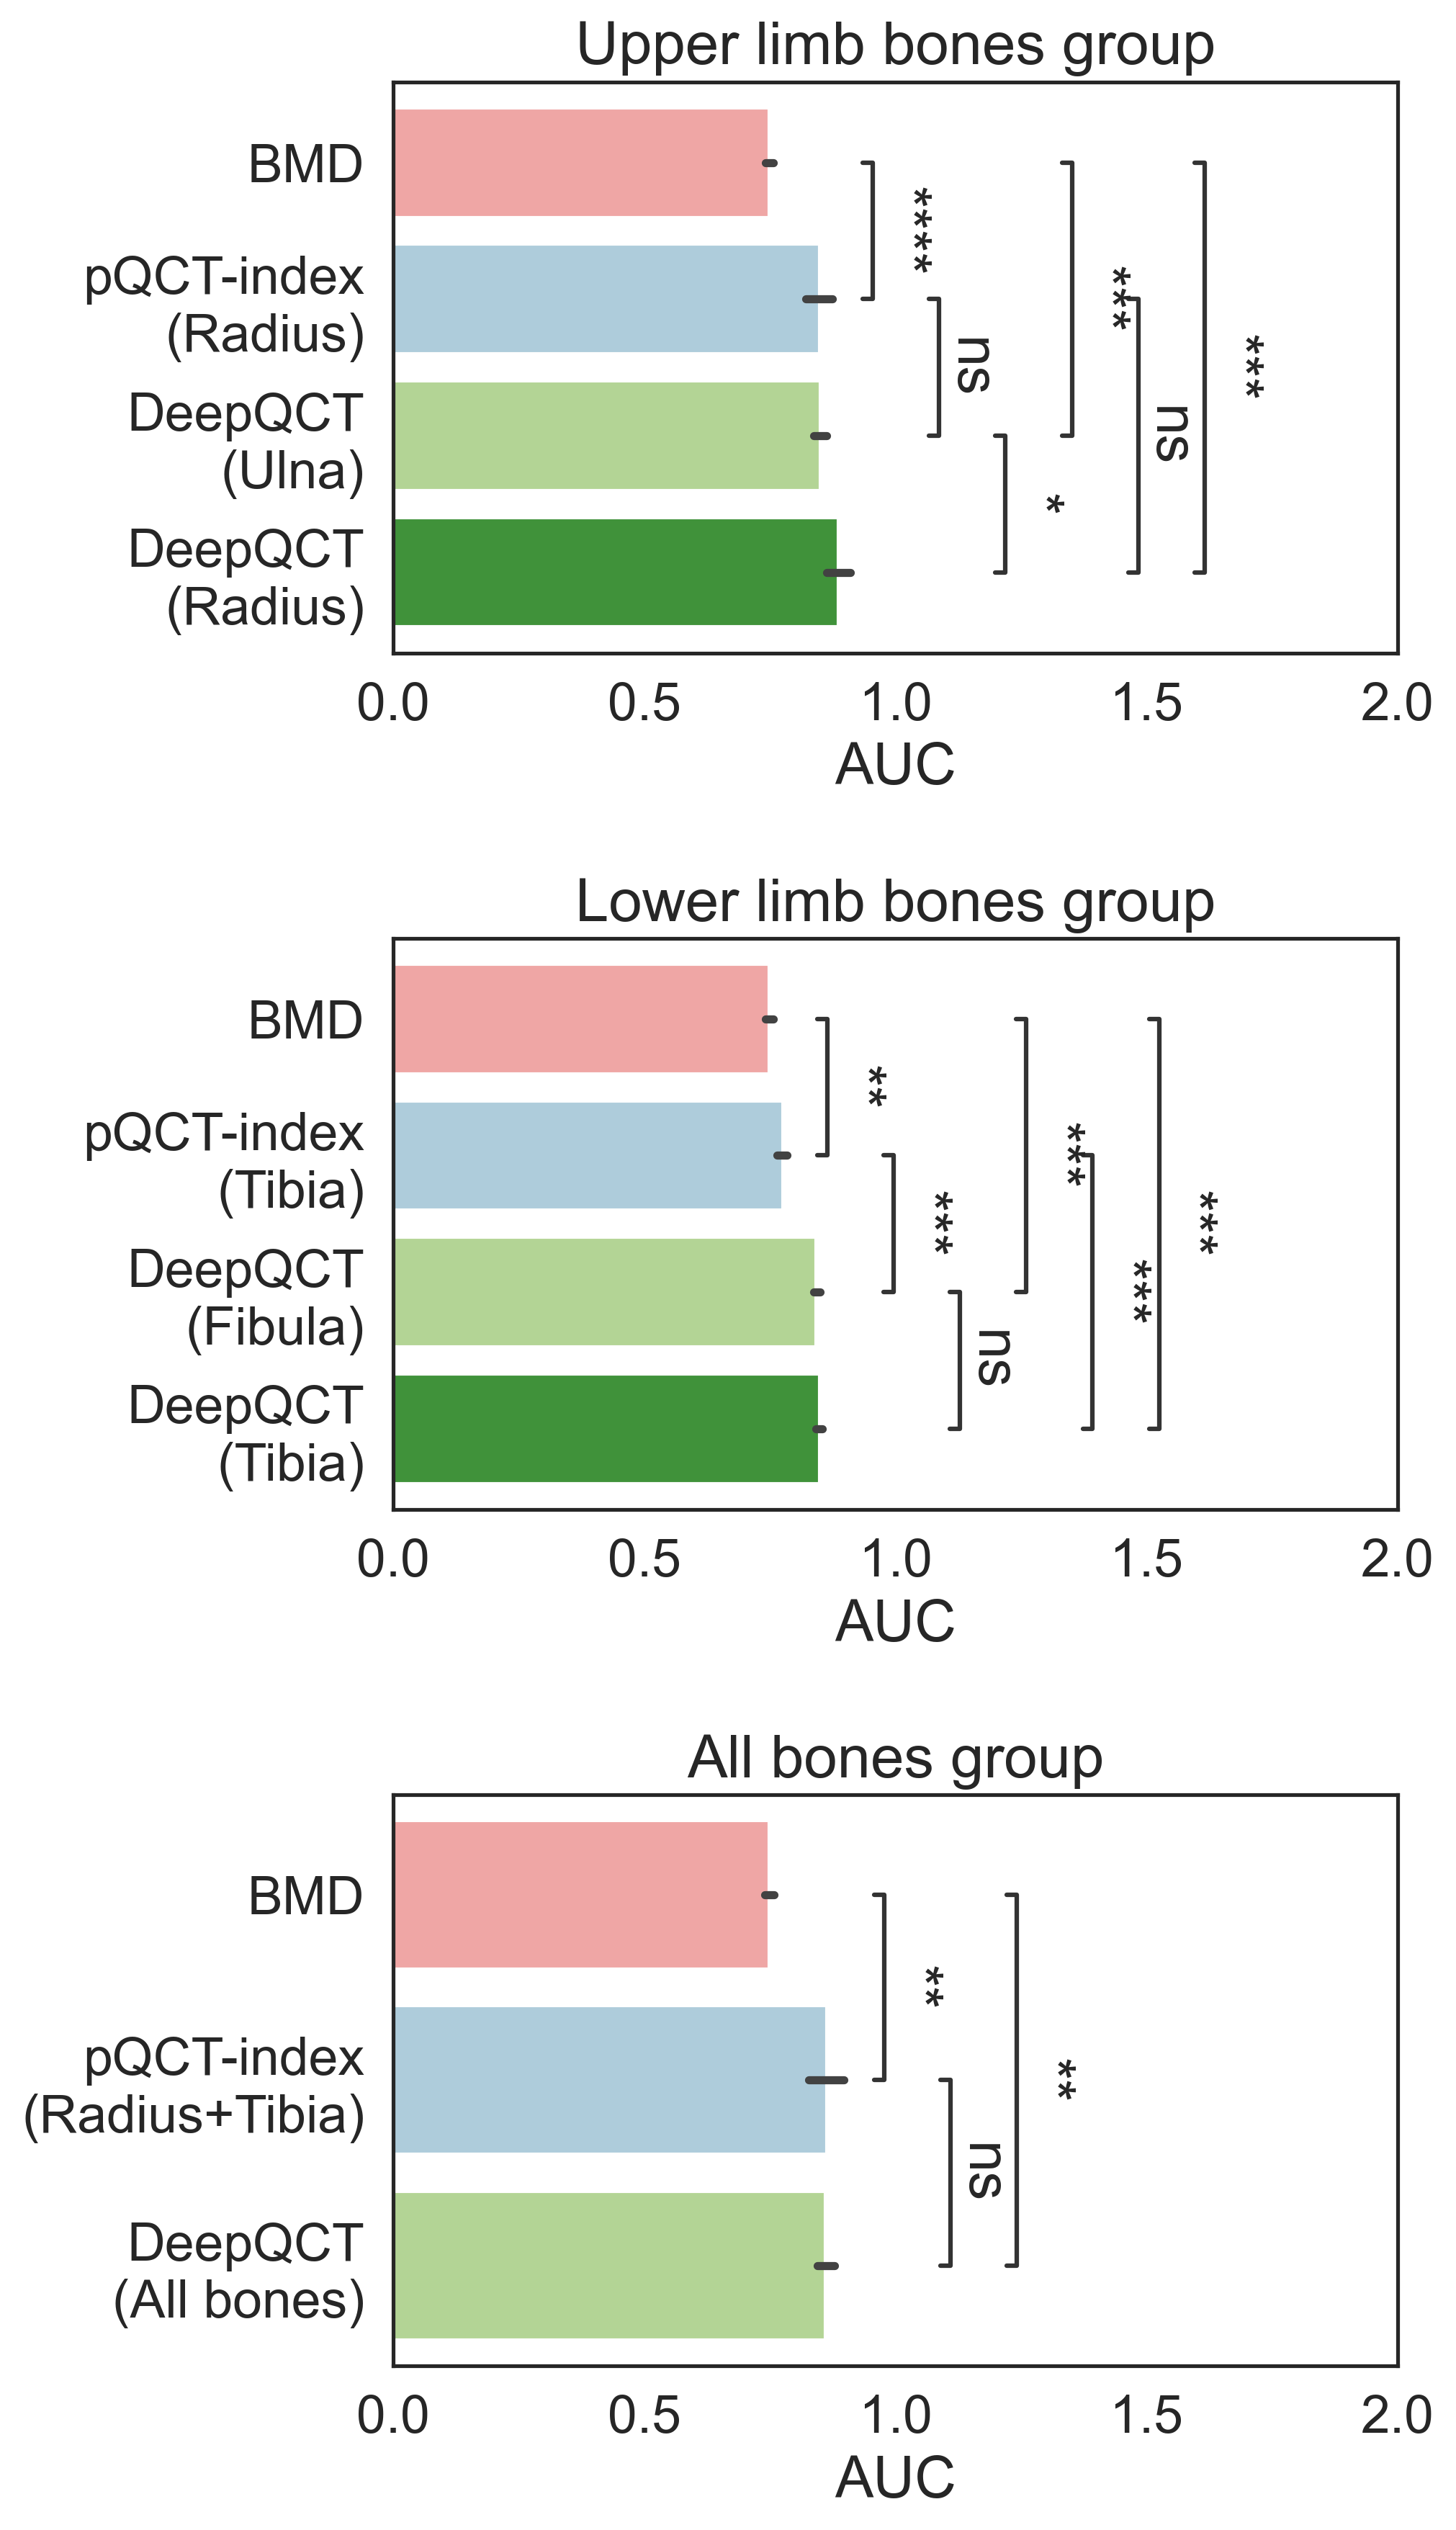

In [17]:
# Task: Fracture Prediction, Internal Test set
sns.set(style='white', font_scale=1.6)
plt.rcParams['figure.dpi'] = 300

dfp = dat.copy()
dfp = dfp[(dfp['model'] != 'Basic+PQCT+PQCT-DL') \
          & (dfp['model'] != 'Basic')]


my_plt = [sns.color_palette("Paired")[i] for i in [4, 0,2,3, 6,7]]

# bone_name_keys = {'tibia':'Tibia', 'fibula':'Fibula', 'radius':'Radius', 'ulna':'Ulna', 'all':'All'}


# dfp['bone'] = [bone_name_keys[x] for x in dfp['bone']]

for metric in ['auc']:#,'acc','f1','precision','recall']:
    modeltype = 'logistic'

    fig, axes = plt.subplots(figsize=(6,14), nrows=3)
    plt.subplots_adjust(hspace=.5)

    dfpp = dfp[(dfp['metric']==metric) & (dfp['fusionMethod']==modeltype)]

    for idx,bone in enumerate(['Upper limb','Lower limb','All']):

        name = 'Upper limb bones group' if idx==0 \
                else 'Lower limb bones group' if idx==1 \
                else 'All bones group'
        
        ax = axes.flatten()[idx]

        new_order = ['Basic+BMD','Basic+PQCT','Basic+PQCT-DL(small bone)','Basic+PQCT-DL(large bone)'] if bone!='All' \
                     else ['Basic+BMD','Basic+PQCT','Basic+PQCT-DL(all bones)']

        tmp = dfpp[dfpp['bone']==bone]
        tmp['score'] = tmp['score'].astype(float)
        tmp['model'] = pd.Categorical(tmp['model'], categories=new_order, ordered=True)
        
        sns.barplot(data=tmp, y='model',x='score', palette=my_plt, 
                    order=new_order, ax=ax, orient='h')
        ax.set_xlim([0,1])

        title = modeltype.capitalize() # 'Random Forest'

        yticklabels = ['BMD','pQCT-index\n(Radius)','DeepQCT\n(Ulna)','DeepQCT\n(Radius)'] if bone=='Upper limb' \
                   else ['BMD','pQCT-index\n(Tibia)','DeepQCT\n(Fibula)','DeepQCT\n(Tibia)'] if bone=='Lower limb' \
                   else ['BMD','pQCT-index\n(Radius+Tibia)','DeepQCT\n(All bones)'] 

        xlabel = 'F1 score' if metric=='f1' else 'Accuracy' if metric=='acc' else 'AUC' if metric=='auc' else 'Precision' if metric=='precision' else 'Recall' if metric=='recall' else None
      
        pairs = [(new_order[i],new_order[j]) \
                 for i in range(len(new_order)) \
                 for j in range(len(new_order)) if i<j ]
        
        annotator = Annotator(ax, pairs, data=tmp, y='model',x='score', 
                              comparisons_correction='fdr_bh', orient='h')
        annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
        annotator.apply_and_annotate()

        
        ax.set_title('')#(f'{title}')
        ax.set_xlabel(xlabel)#('Accuracy')#(f'{metric.capitalize()}')
        ax.set_yticklabels(yticklabels)
        ax.set_ylabel('')
        
        ax.set_xlim(0,2)
        
        ax.set_title(name, fontsize=20)

    

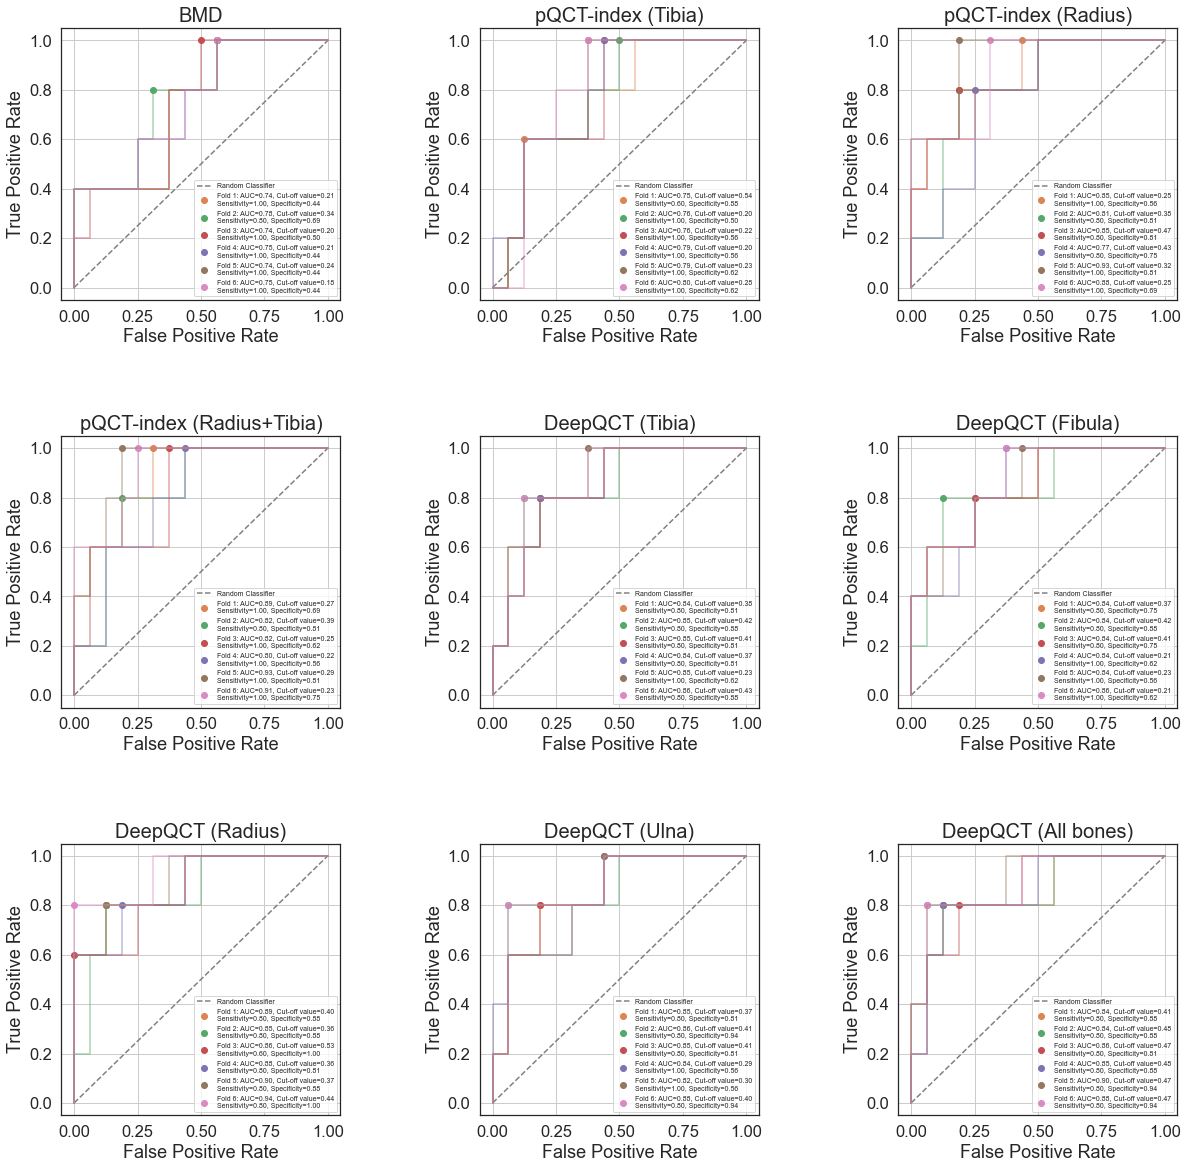

In [9]:
sns.set(style='white', font_scale=1.5)

dfp = dat.copy()
dfp = dfp[(dfp['model'] != 'Basic+PQCT+PQCT-DL') \
          & (dfp['model'] != 'Basic') \
          & (dfp['fusionMethod']=='logistic')]

dfp['name_new'] = dfp.apply(lambda row: f"{row['trial']}\n{row['model']}", axis=1)

models_brief_keys = {
    '1A1\nBasic+BMD':'BMD',
    '1A1\nBasic+PQCT':'pQCT-index (Tibia)',
    '1A3\nBasic+PQCT':'pQCT-index (Radius)',
    '1A5\nBasic+PQCT':'pQCT-index (Radius+Tibia)',
    '1A1\nBasic+PQCT-DL(large bone)':'DeepQCT (Tibia)',
    '1A2\nBasic+PQCT-DL(small bone)':'DeepQCT (Fibula)',
    '1A3\nBasic+PQCT-DL(large bone)':'DeepQCT (Radius)',
    '1A4\nBasic+PQCT-DL(small bone)':'DeepQCT (Ulna)',
    '1A5\nBasic+PQCT-DL(all bones)':'DeepQCT (All bones)'
}

dfp = dfp[dfp['name_new'].isin(models_brief_keys.keys())]
dfp['fold'] = dfp['fold'].astype(int)

fig,axes = plt.subplots(figsize=(20, 20), ncols=3, nrows=3)
plt.subplots_adjust(wspace=.5, hspace=.5)

for idx,model in enumerate(models_brief_keys.keys()):
    
    ax = axes.flatten()[idx]
    title = models_brief_keys[model]
    tmp = dfp[dfp['name_new']==model]

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
    ax.grid(True)
    
    for fold in range(1,7):

        tmpp = tmp[tmp['fold']==fold]
        auc = tmpp[tmpp['metric']=='auc']['score'].values[0]

        fpr = tmpp[tmpp['metric']=='fpr']['score'].values[0]
        tpr = tmpp[tmpp['metric']=='tpr']['score'].values[0]
        thresholds = tmpp[tmpp['metric']=='thresholds']['score'].values[0]

        J = tpr - fpr
        optimal_idx = np.argmax(J)
        optimal_threshold = thresholds[optimal_idx]
        optimal_sen = tpr[optimal_idx]
        optimal_spe = (1-fpr)[optimal_idx]


        ax.plot(fpr, tpr, color=sns.color_palette("deep")[fold], alpha=.5)

        ax.scatter(fpr[optimal_idx], tpr[optimal_idx], color=sns.color_palette("deep")[fold], 
                    label=f'Fold {fold}: AUC={auc:.2f}, Cut-off value={optimal_threshold:.2f}\nSensitivity={optimal_sen:.2f}, Specificity={optimal_spe:.2f}')

        ax.legend(loc='lower right', fontsize=7)
        ax.set_title(title, fontsize=20)

    


### AUC across models

In [7]:
dfp = dat.copy()
dfp = dfp[(dfp['model'] != 'Basic+PQCT+PQCT-DL') \
          & (dfp['model'] != 'Basic') \
          & (dfp['fusionMethod'] == 'logistic') 
         ]


dfp['name_new'] = dfp.apply(lambda row: f"{row['trial']}\n{row['model']}", axis=1)

models_brief = [
     '1A1\nBasic+BMD',
     '1A1\nBasic+PQCT','1A3\nBasic+PQCT','1A5\nBasic+PQCT',
     '1A1\nBasic+PQCT-DL(large bone)','1A2\nBasic+PQCT-DL(small bone)',
     '1A3\nBasic+PQCT-DL(large bone)','1A4\nBasic+PQCT-DL(small bone)',
     '1A5\nBasic+PQCT-DL(all bones)'
    ]


dfp = dfp[dfp['name_new'].isin(models_brief)]

#----------------------------------------
out_plt = {}
for model in models_brief:
    
    tmp = dfp[(dfp['name_new']==model) & (dfp['metric']=='auc')]
    fold_best = tmp.iloc[np.argmax(tmp['score'].values)]['fold']
    
    print(model, 'best fold:',fold_best)
    tmp_best = dfp[(dfp['name_new']==model) & (dfp['fold']==fold_best)]
    
    auc = tmp_best[tmp_best['metric']=='auc']['score'].values[0]
    fpr = tmp_best[tmp_best['metric']=='fpr']['score'].values[0]
    tpr = tmp_best[tmp_best['metric']=='tpr']['score'].values[0]
    thresholds = tmp_best[tmp_best['metric']=='thresholds']['score'].values[0]
    
    J = tpr - fpr
    optimal_idx = np.argmax(J)
    optimal_threshold = thresholds[optimal_idx]
    optimal_sen = tpr[optimal_idx]
    optimal_spe = (1-fpr)[optimal_idx]

    out_plt[model] = [auc,fpr,tpr,thresholds, optimal_idx,optimal_threshold,optimal_sen,optimal_spe]
    
#----------------------------------------
meta = pd.read_csv('../data/meta/chivos_fragfrax_final.csv', index_col=0) #[['ptid','label','sex','age','height','weight']]

# meta['age'] = meta['age'] / 100
meta['height'] = meta['height'] / 100 # original in cm
# meta['weight'] = meta['weight'] / 10 # original in kg

# for name in ['RADIUS_BV/TV','TIBIA_BV/TV']:
#     meta[name] *= 100
meta.columns = [x.replace('BV/TV', 'BV_TV') for x in meta.columns]


#----------------------------------------
trial_name = '1A1' # test indices are the same for each trial_name

indices_dict = pkl.load(open(f'../data/meta/indices_{trial_name}.pkl', 'rb'))
test_indices = indices_dict['test_indices']

df_test = meta.iloc[test_indices,:]

test_pred = (df_test[bmd_params].min(axis=1)<=-2.5) * 1
test_Y = df_test['fragility_fracture']

auc = roc_auc_score(test_Y, test_pred, labels=[0,1]) # 2 class
fpr, tpr, thresholds = roc_curve(test_Y, test_pred)
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]
optimal_sen = tpr[optimal_idx]
optimal_spe = (1-fpr)[optimal_idx]
    
out_plt['BMD'] = [auc,fpr,tpr,thresholds, optimal_idx,optimal_threshold,optimal_sen,optimal_spe]

out_plt

1A1
Basic+BMD best fold: 2
1A1
Basic+PQCT best fold: 6
1A3
Basic+PQCT best fold: 5
1A5
Basic+PQCT best fold: 5
1A1
Basic+PQCT-DL(large bone) best fold: 6
1A2
Basic+PQCT-DL(small bone) best fold: 6
1A3
Basic+PQCT-DL(large bone) best fold: 6
1A4
Basic+PQCT-DL(small bone) best fold: 6
1A5
Basic+PQCT-DL(all bones) best fold: 5


{'1A1\nBasic+BMD': [0.775,
  array([0.    , 0.    , 0.    , 0.25  , 0.25  , 0.3125, 0.3125, 0.5625,
         0.5625, 1.    ]),
  array([0. , 0.2, 0.4, 0.4, 0.6, 0.6, 0.8, 0.8, 1. , 1. ]),
  array([1.64277189, 0.64277189, 0.59733483, 0.38097003, 0.37191776,
         0.36768962, 0.33837506, 0.17444237, 0.15918125, 0.03719706]),
  6,
  0.3383750613804437,
  0.8,
  0.6875],
 '1A1\nBasic+PQCT': [0.7999999999999999,
  array([0.    , 0.0625, 0.125 , 0.125 , 0.25  , 0.25  , 0.375 , 0.375 ,
         1.    ]),
  array([0. , 0. , 0. , 0.6, 0.6, 0.8, 0.8, 1. , 1. ]),
  array([1.70786405, 0.70786405, 0.63943259, 0.48269691, 0.41269574,
         0.39663232, 0.33888461, 0.2797716 , 0.04534598]),
  7,
  0.27977160181981386,
  1.0,
  0.625],
 '1A3\nBasic+PQCT': [0.925,
  array([0.    , 0.    , 0.    , 0.1875, 0.1875, 1.    ]),
  array([0. , 0.2, 0.6, 0.6, 1. , 1. ]),
  array([1.60117378, 0.60117378, 0.47590083, 0.40541062, 0.32484818,
         0.09689745]),
  4,
  0.3248481810129073,
  1.0,
  0.8125],


In [8]:
# to double confirm performance of BMD alone (min T<=-2.5)
from sklearn.metrics import confusion_matrix, roc_auc_score

df = pd.DataFrame({'pred_label':test_pred,'true_label':test_Y})

tn, fp, fn, tp = confusion_matrix(df['true_label'], df['pred_label']).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Calculate AUC (Area Under the ROC Curve)
auc = roc_auc_score(df['true_label'], df['pred_label'])

sensitivity, specificity, auc

(0.4, 0.6875, 0.54375)

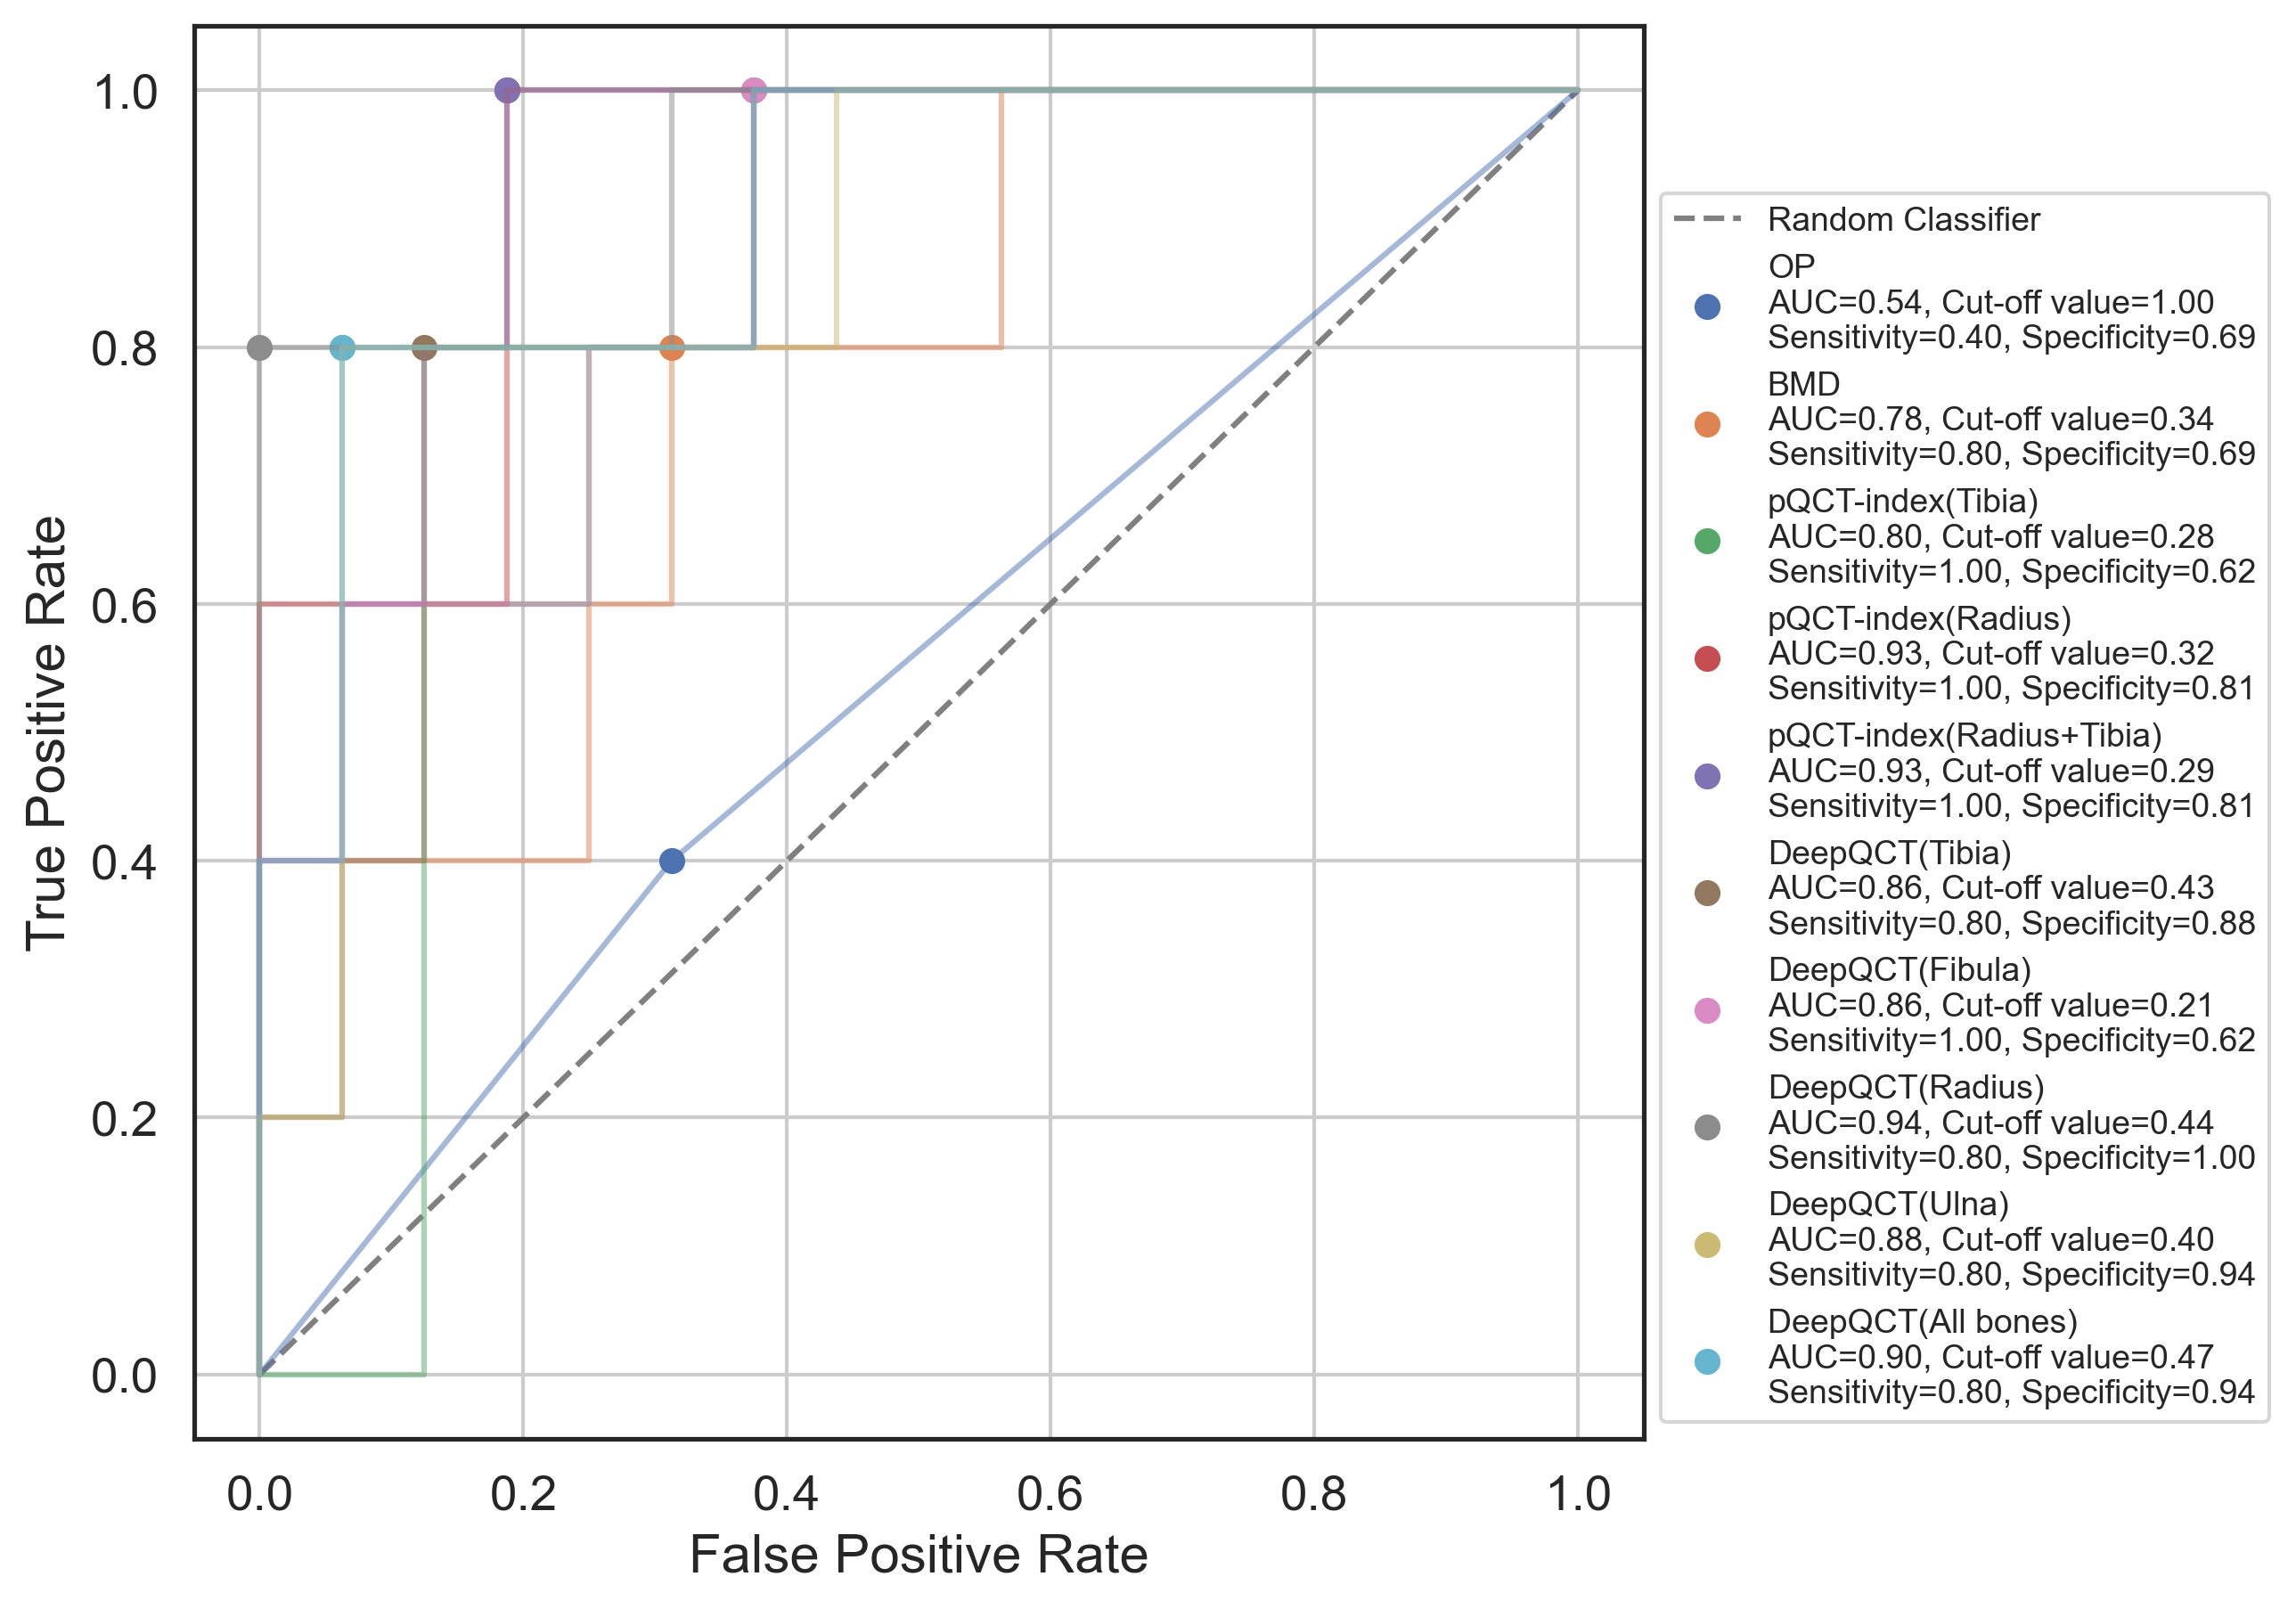

In [12]:
models_brief_keys = {
    'BMD':'OP',
    '1A1\nBasic+BMD':'BMD',
    '1A1\nBasic+PQCT':'pQCT-index(Tibia)',
    '1A3\nBasic+PQCT':'pQCT-index(Radius)',
    '1A5\nBasic+PQCT':'pQCT-index(Radius+Tibia)',
    '1A1\nBasic+PQCT-DL(large bone)':'DeepQCT(Tibia)',
    '1A2\nBasic+PQCT-DL(small bone)':'DeepQCT(Fibula)',
    '1A3\nBasic+PQCT-DL(large bone)':'DeepQCT(Radius)',
    '1A4\nBasic+PQCT-DL(small bone)':'DeepQCT(Ulna)',
    '1A5\nBasic+PQCT-DL(all bones)':'DeepQCT(All bones)'
}

plt.figure(figsize=(7, 7))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.grid(True)

plt.rcParams['figure.dpi'] = 300
        
for idx,model in enumerate(models_brief_keys.keys()):
    
    title = models_brief_keys[model]
    auc,fpr,tpr,thresholds, optimal_idx,optimal_threshold,optimal_sen,optimal_spe = out_plt[model]

    plt.plot(fpr, tpr, color=sns.color_palette("deep")[idx], alpha=.5)

    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color=sns.color_palette("deep")[idx], 
                label=f'{title}\nAUC={auc:.2f}, Cut-off value={optimal_threshold:.2f}\nSensitivity={optimal_sen:.2f}, Specificity={optimal_spe:.2f}')

plt.legend(loc='lower left', fontsize=9, bbox_to_anchor=(1,0))
plt.show()


# PQCT indices 
## Logistic OR

In [65]:
df.columns

Index(['v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9',
       ...
       'TIBIA_Tb_vBMD', 'TIBIA_BV_TV(%)(%)', 'TIBIA_Tb_N', 'TIBIA_Tb_Th',
       'TIBIA_Tb_Sp', 'TIBIA_Ct_Ar', 'TIBIA_Ct_vBMD', 'TIBIA_Ct_Pm',
       'TIBIA_Ct_Po', 'TIBIA_Ct_Th'],
      dtype='object', length=147)

6 {'TIBIA_Tb_Sp', 'TIBIA_Tb_vBMD', 'RADIUS_Ct_Ar', 'TIBIA_Tt_vBMD', 'age', 'TIBIA_BV_TV'}


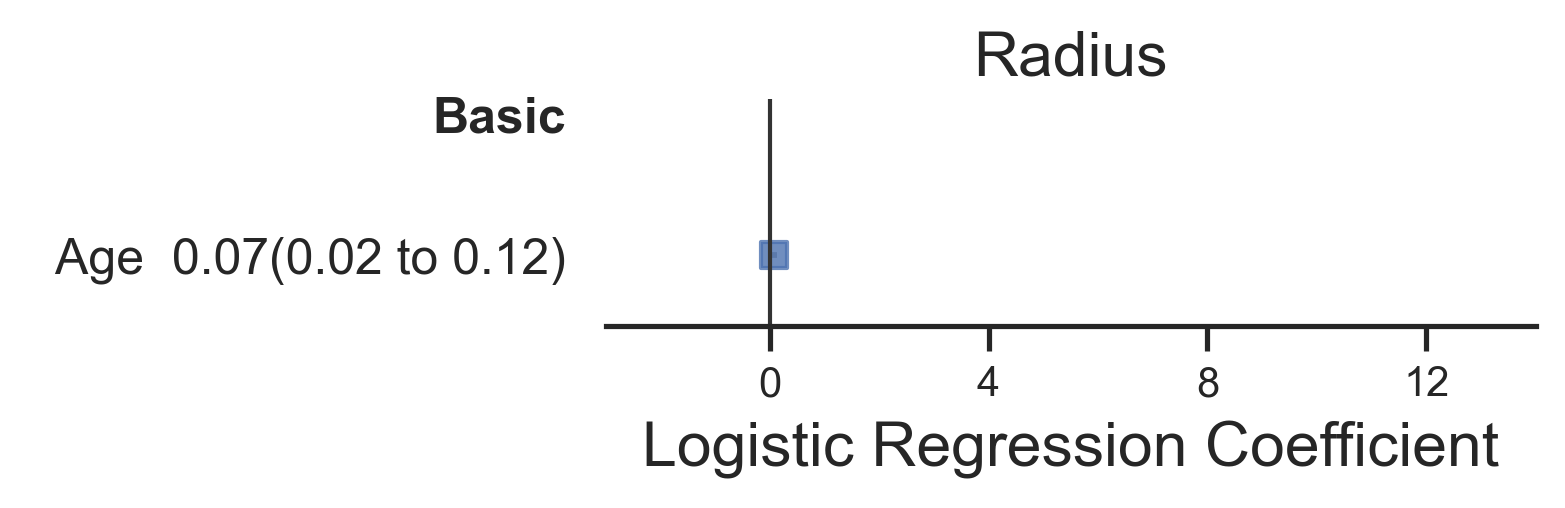

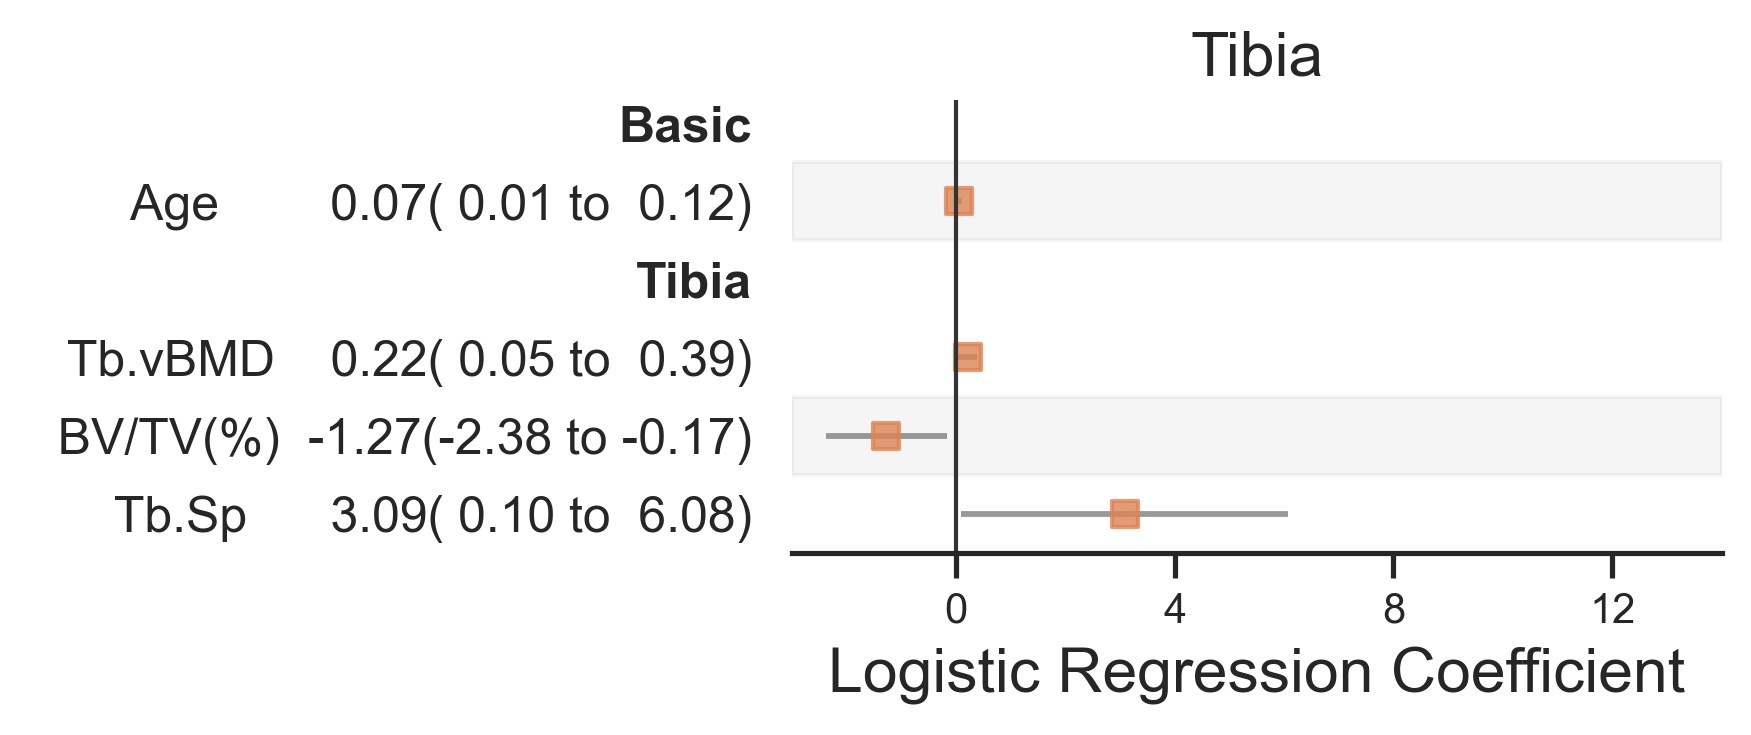

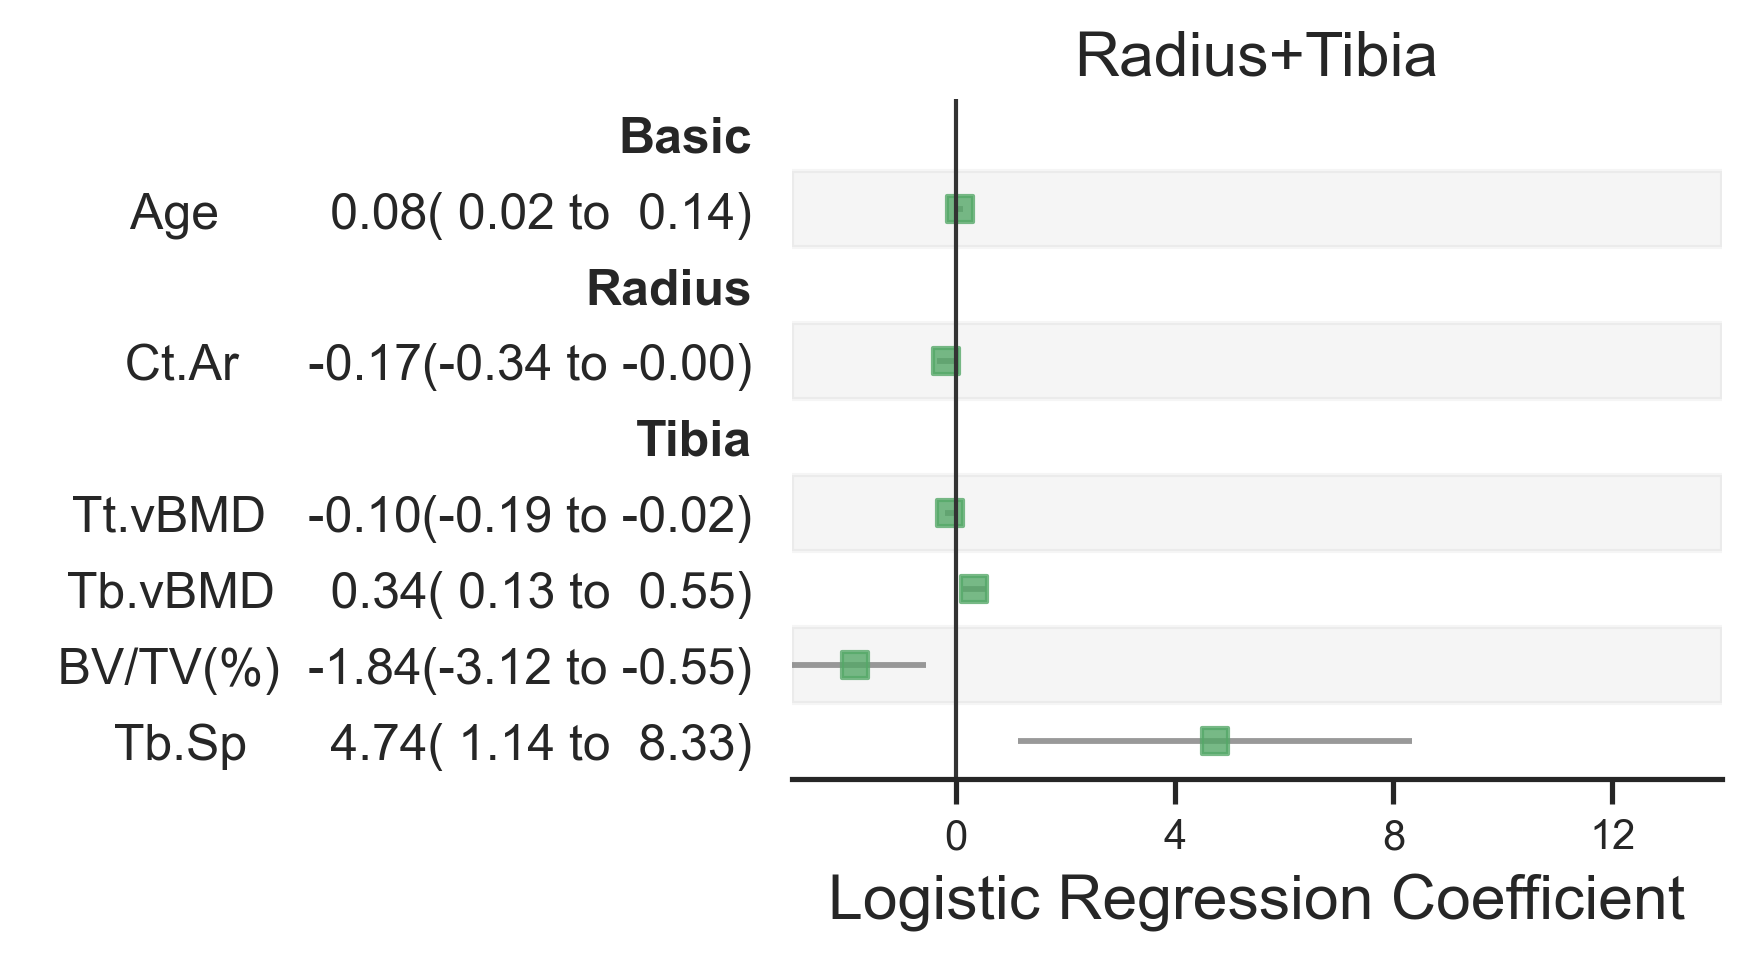

In [75]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import forestplot as fp

bone_name_keys2 = {
    '1A1':'Tibia',
    '1A2':'Fibula',
    '1A3':'Radius',
    '1A4':'Ulna',
    '1A5':'Radius+Tibia'
}


history = {}

k = 6
dim = 128
seed = 2023
splits=KFold(n_splits=k,shuffle=True,random_state=seed)

label_name = 'fragility_fracture'
method = 'logistic'

or_dict = {}
vars_show = set()

#----------------------------------------------------------------------------------------------
meta = pd.read_csv('../data/meta/chivos_fragfrax_final.csv', index_col=0) #[['ptid','label','sex','age','height','weight']]
meta['height'] = meta['height'] / 100 # original in cm
meta.columns = [x.replace('BV/TV', 'BV_TV') for x in meta.columns]

for name in ['RADIUS_BV_TV','TIBIA_BV_TV']:
    meta[name] *= 100

#----------------------------------------------------------------------------------------------
for trial_name in ['1A1','1A3','1A5']: # for pqct indices, 1A1==1A2 and 1A3==1A4
     
    fold = 6 if trial_name=='1A1' \
           else 5 if trial_name=='1A3' \
           else 5 if trial_name=='1A5' else None # best AUC fold for tibia is 6, for raidus is 5, for tibia+radius is 5
        
    pqct_params = pqctparams_keys['tibia_fibula'] if trial_name in ['1A1','1A2', '2A1','2A2'] \
            else pqctparams_keys['raidus_ulna'] if trial_name in ['1A3','1A4', '2A3','2A4'] \
            else pqctparams_keys['four_bones']


   
    col_keys = {       
    'Basic+PQCT':['age','height','weight']+pqct_params,  

#     'Basic+PQCT-DL':['age','height','weight']+bmd_params+[f'v{i}' for i in range(128)] 
    }
        
    sel_col = 'Basic+PQCT'
    


    indices_dict = pkl.load(open(f'../data/meta/indices_{trial_name}.pkl', 'rb'))
    meta_recoded = indices_dict['recoded_meta']
    test_indices = indices_dict['test_indices']
    train_indices = [idx for idx in meta_recoded.index if idx not in test_indices]#indices_dict[f'train_indices_noaug_fold{fold}']

    df = pd.read_csv(f'../data/embeds/{trial_name}_fold{fold}_dim{dim}.csv', index_col=0)
    df['ptid'] = df['ptid'].astype(int)
    df = pd.merge(df, meta[['ptid','sex','age','height','weight']+pqct_params], on='ptid')
    assert_frame_equal(df[['ptid']], meta_recoded[['ptid']])

    indices_dict[f'embeddings_{fold}'] = df

    sel_colnames = col_keys[sel_col]
    df_train = df.iloc[train_indices,:]

    train_X = df_train.loc[:,sel_colnames].values # [N, 256]
    train_Y = df_train[label_name].values

    all_colnames = sel_colnames + [label_name]
    model = smf.glm(f'{label_name} ~ {" + ".join(sel_colnames)}', 
                    df_train[all_colnames], 
                    family=sm.families.Binomial()).fit()

    # print(model.summary())
    ft_imp_tmp = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]
#         ft_imp_tmp.index = [x.replace('TIBIA_', '').replace('RADIUS_', '') for x in ft_imp_tmp.index]

#         print(trial_name, fold)
#         print(ft_imp_tmp[ft_imp_tmp['P>|z|']<0.05])
#         print('\n\n')

    vars_tmp = set(ft_imp_tmp[ft_imp_tmp['P>|z|']<0.05].index.tolist())
#     print(vars_tmp)
    vars_show = vars_show | vars_tmp

    or_dict[trial_name] = ft_imp_tmp

# or_dict
print(len(vars_show), vars_show)



my_plt = sns.color_palette("deep")
sns.set(style='white', font_scale=2)

for idx,trial_name in enumerate(['1A3','1A1','1A5']):
    
    color = my_plt[idx]

    ft_imp_tmp = or_dict[trial_name]
    dfp = ft_imp_tmp[ft_imp_tmp['P>|z|']<0.05].reset_index()

    for col in ['coef',"[0.025", "0.975]"]:
        dfp[col] = dfp[col].astype(float)

    dfp['var'] = [x.replace('TIBIA_', '').replace('RADIUS_', '').replace('_','.').replace('weight','Weight').replace('age','Age').replace('BV.TV','BV/TV(%)') for x in dfp['index']]
    dfp['group'] = ['Tibia' if x.startswith('TIBIA') 
                    else 'Radius' if x.startswith('RADIUS') 
                    else 'Basic' for x in dfp['index']]

    ht = 1 if idx==0 else 2 if idx==1 else 3
    ax = fp.forestplot(dfp,  figsize=(4,ht),# the dataframe with results data
                  estimate="coef",  # col containing estimated effect size 
                  ll="[0.025", hl="0.975]",  # columns containing conf. int. lower and higher limits
                  groupvar='group',
                  varlabel="var",  # column containing variable label
                  color_alt_rows=True,  # Gray alternate rows
                  ylabel="",  # ylabel to print
                  **{"ylabel1_size": 11}, # control size of printed ylabel
                  flush=False, 
                  fontfamily='Sans Serif', markercolor=color,
                  decimal_precision= 2
                  )

    ax.set_xlim([-3,14])
    # ax.axvline(x=0, color='grey', linestyle='--')
    ax.set_xlabel('Logistic Regression Coefficient', fontsize=15)

    title = bone_name_keys2[trial_name]
    ax.set_title(title, fontsize=15)

## Clustering

1.  `embed[pqctparams]`, it is based on modified scale (in training, values in meta is re-scaled to facilitate multi-task learning)
```python
for name in ['RADIUS_Tt_Ar', 'RADIUS_Tt_vBMD', 'RADIUS_Tb_Ar', 'RADIUS_Tb_vBMD', 'RADIUS_Ct_Ar','RADIUS_Ct_vBMD','RADIUS_Ct_Pm',  'TIBIA_Tt_Ar', 'TIBIA_Tt_vBMD', 'TIBIA_Tb_Ar', 'TIBIA_Tb_vBMD', 'TIBIA_Ct_Ar','TIBIA_Ct_vBMD','TIBIA_Ct_Pm']:
    meta[name] /= 100
for name in ['RADIUS_Ct_Po', 'TIBIA_Ct_Po']:
    meta[name] *= 100
image_label = meta['fragility_fracture']
```

2. Fortunately, because the Spearman correlation is based on the ranks of the data rather than their raw values, scaling one variable (such as multiplying x by 100) will not affect the ranks of the data within that variable.



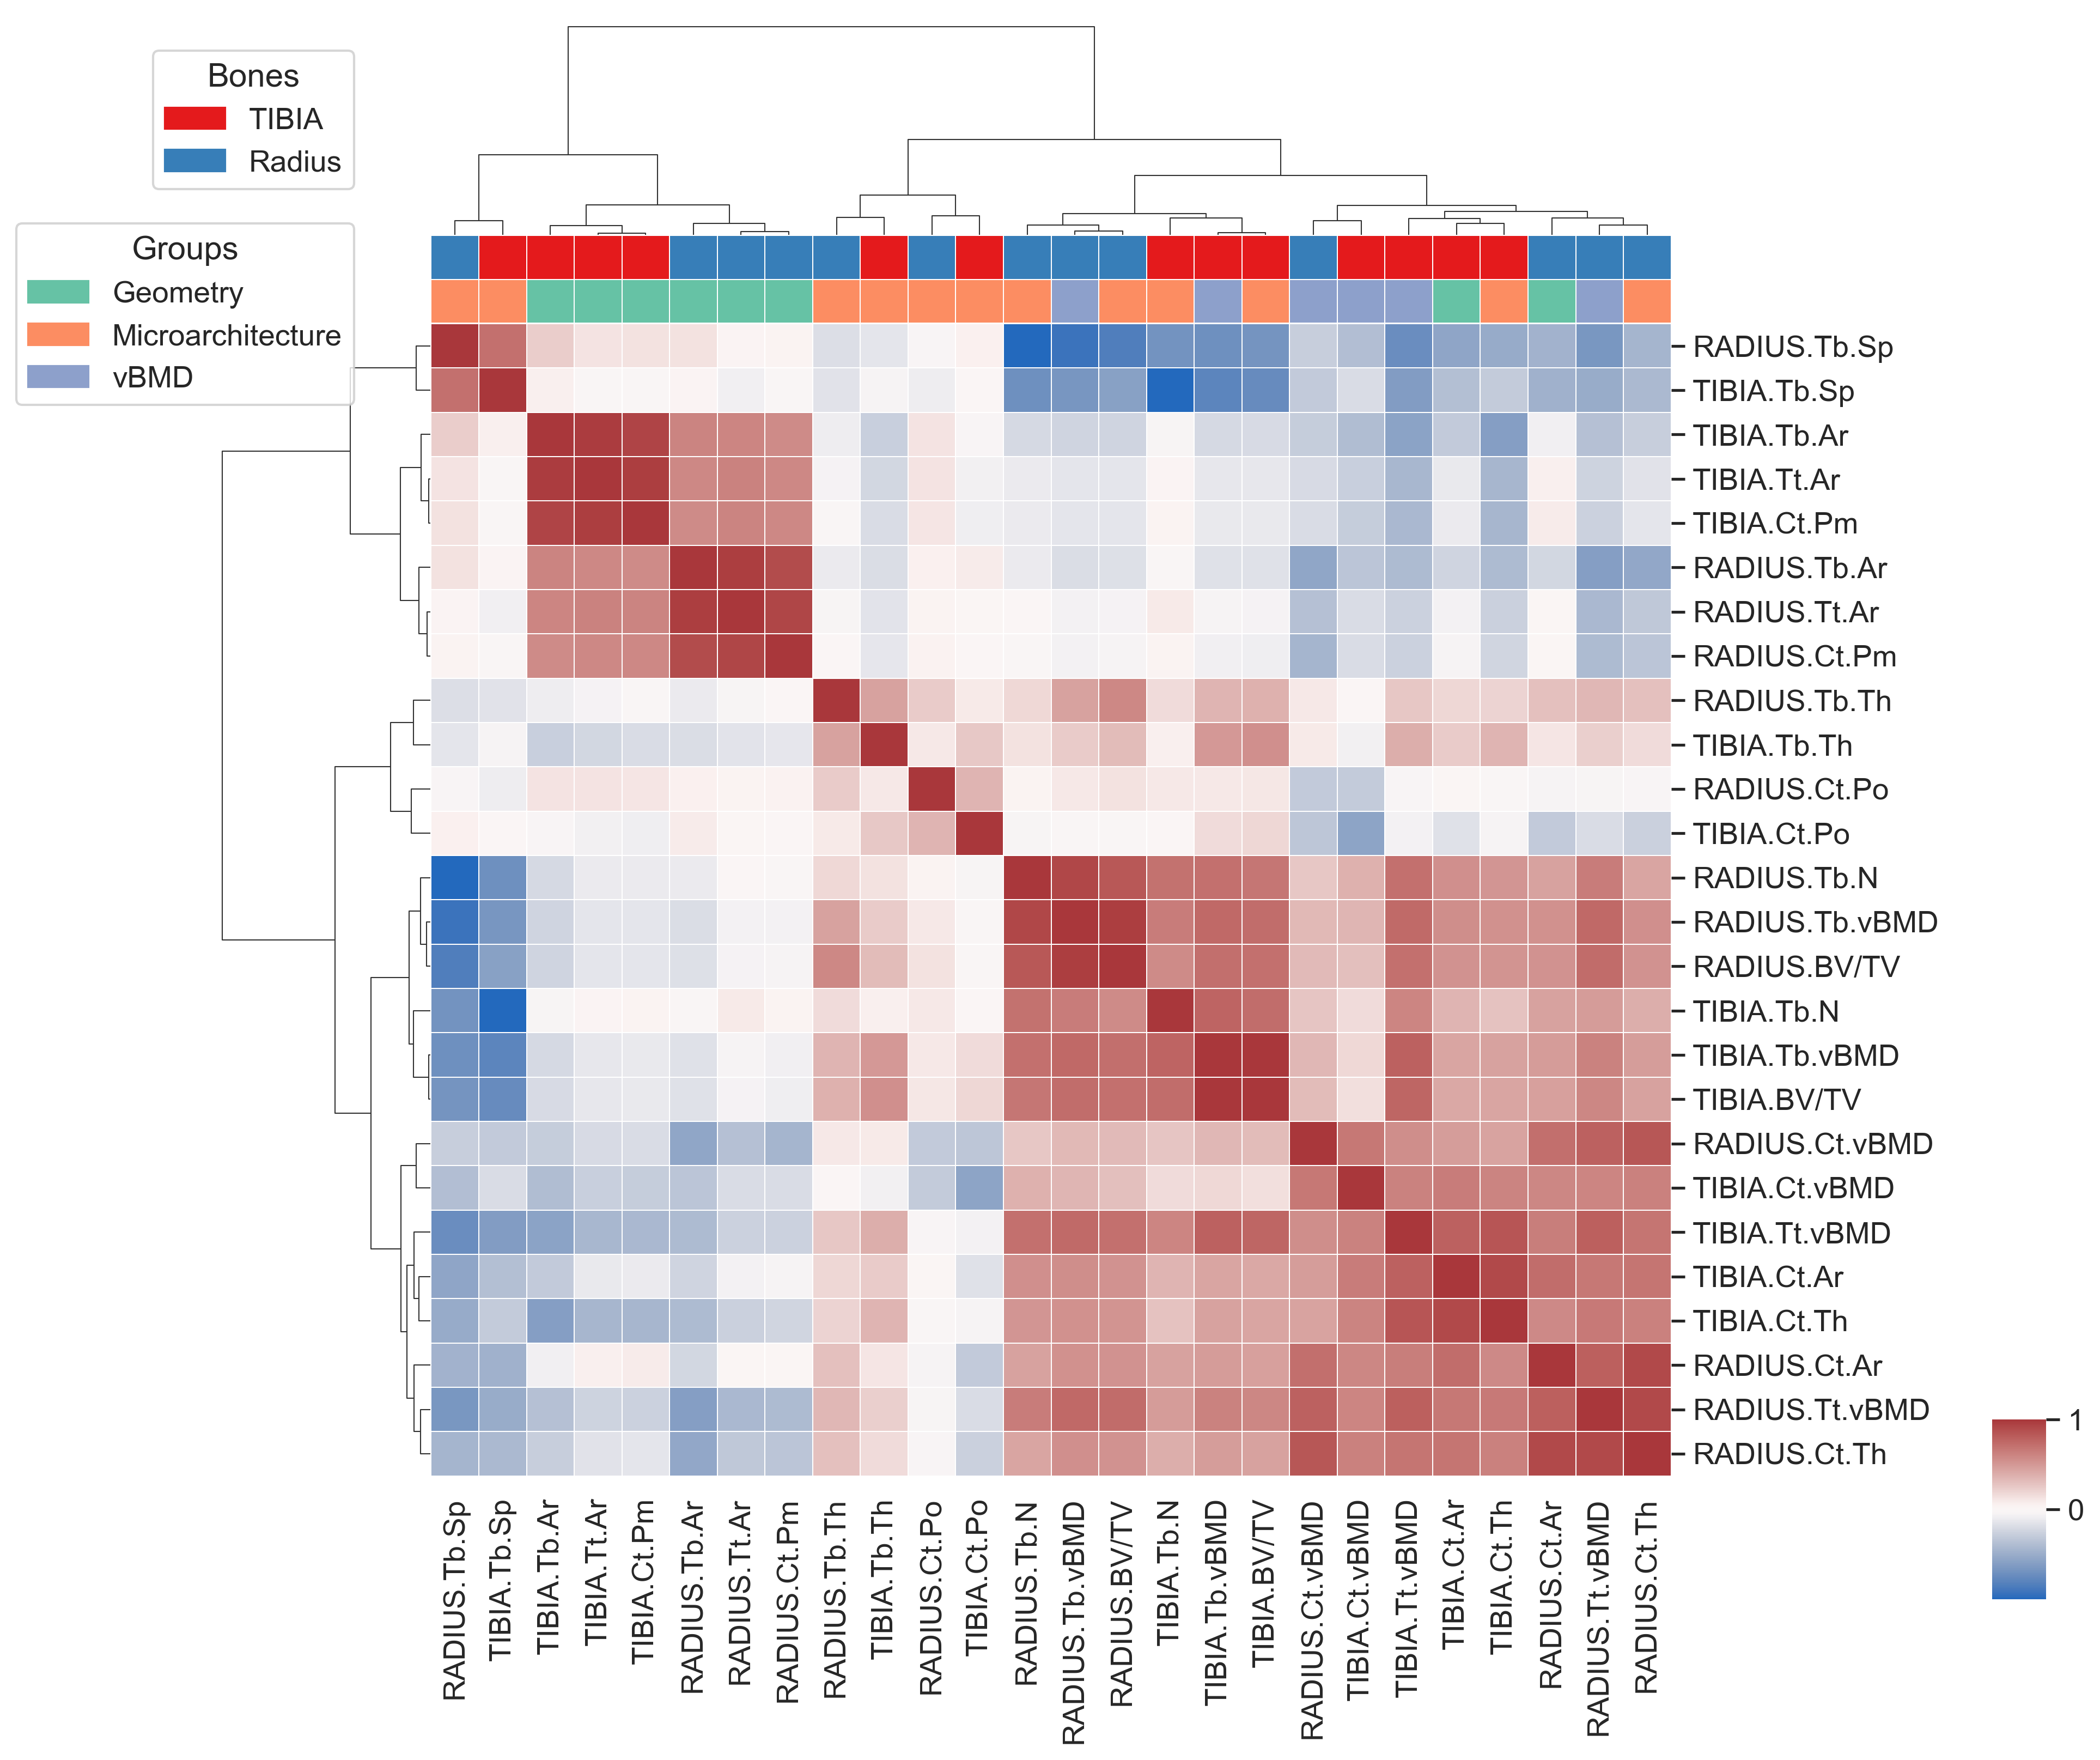

In [50]:
sns.set(style='white', font_scale=1.2)

pqctparams = ['RADIUS_Tt_Ar', 'RADIUS_Tt_vBMD', 'RADIUS_Tb_Ar', 'RADIUS_Tb_vBMD', 'RADIUS_BV/TV', 'RADIUS_Tb_N', 'RADIUS_Tb_Th', 'RADIUS_Tb_Sp', 'RADIUS_Ct_Ar', 'RADIUS_Ct_vBMD', 'RADIUS_Ct_Pm', 'RADIUS_Ct_Po', 'RADIUS_Ct_Th', 'TIBIA_Tt_Ar', 'TIBIA_Tt_vBMD', 'TIBIA_Tb_Ar', 'TIBIA_Tb_vBMD', 'TIBIA_BV/TV', 'TIBIA_Tb_N', 'TIBIA_Tb_Th', 'TIBIA_Tb_Sp', 'TIBIA_Ct_Ar', 'TIBIA_Ct_vBMD', 'TIBIA_Ct_Pm', 'TIBIA_Ct_Po', 'TIBIA_Ct_Th']

embed = pd.read_csv(f'../data/meta/chivos_fragfrax_final.csv', index_col=0)

indices_dict = pkl.load(open(f'../data/meta/indices_{trial_name}.pkl', 'rb'))

dfp = indices_dict['recoded_meta']
assert np.all(dfp['ptid']==embed['ptid'])

_X = embed[pqctparams]

_X.columns = [x.replace('_','.') for x in _X.columns]
# _X.index = [x.replace('_','.') for x in _X.index]

# vars
df_corr = _X.corr(method='spearman')

bones = ['Radius' if x.startswith('RADIUS') else 'TIBIA' for x in df_corr.columns]

pqct_group_keys = {
    'Geometry':['Tt.Ar','Ct.Ar','Tb.Ar','Ct.Pm'],
    'vBMD':['Tt.vBMD','Ct.vBMD','Tb.vBMD'],
    'Microarchitecture':['BV/TV','Tb.N','Tb.Th','Tb.Sp','Ct.Th','Ct.Po']
}

def determine_group(column_name):
    for group, keys in pqct_group_keys.items():
        if any(key in column_name for key in keys):
            return group
    return 'Other'

groups = [determine_group(x) for x in df_corr.columns]

labels1 = bones
lut1 = dict(zip(set(labels1), sns.color_palette('Set1',2)), alpha=.5)
col_colors1 = pd.DataFrame(labels1).iloc[:,0].map(lut1)

labels2 = groups
lut2 = dict(zip(set(labels2), sns.color_palette('Set2',3)), alpha=1)
col_colors2 = pd.DataFrame(labels2).iloc[:,0].map(lut2)

import matplotlib.patches as mpatches
legend_patches1 = [mpatches.Patch(color=lut1[label], label=label) for label in set(labels1)]
legend_patches2 = [mpatches.Patch(color=lut2[label], label=label) for label in set(labels2)]


g = sns.clustermap(df_corr, figsize=(11,11), method='ward', 
                   linewidth=.1,
                   col_colors=[col_colors1, col_colors2],
                   cmap='vlag', dendrogram_ratio=(.15,.15))

leg1 = g.ax_heatmap.legend(handles=legend_patches1, title='Bones', loc='upper right', bbox_to_anchor=(-.05, 1.25))
g.ax_heatmap.add_artist(leg1)
g.ax_heatmap.legend(handles=legend_patches2, title='Groups', loc='upper right', bbox_to_anchor=(-.05, 1.1))


cbar = g.cax
x0,y0,x1,y1 = np.array(g.ax_heatmap.get_position()).flatten()
cbar.set_position([1.01, 0.1, 0.03, 0.1])


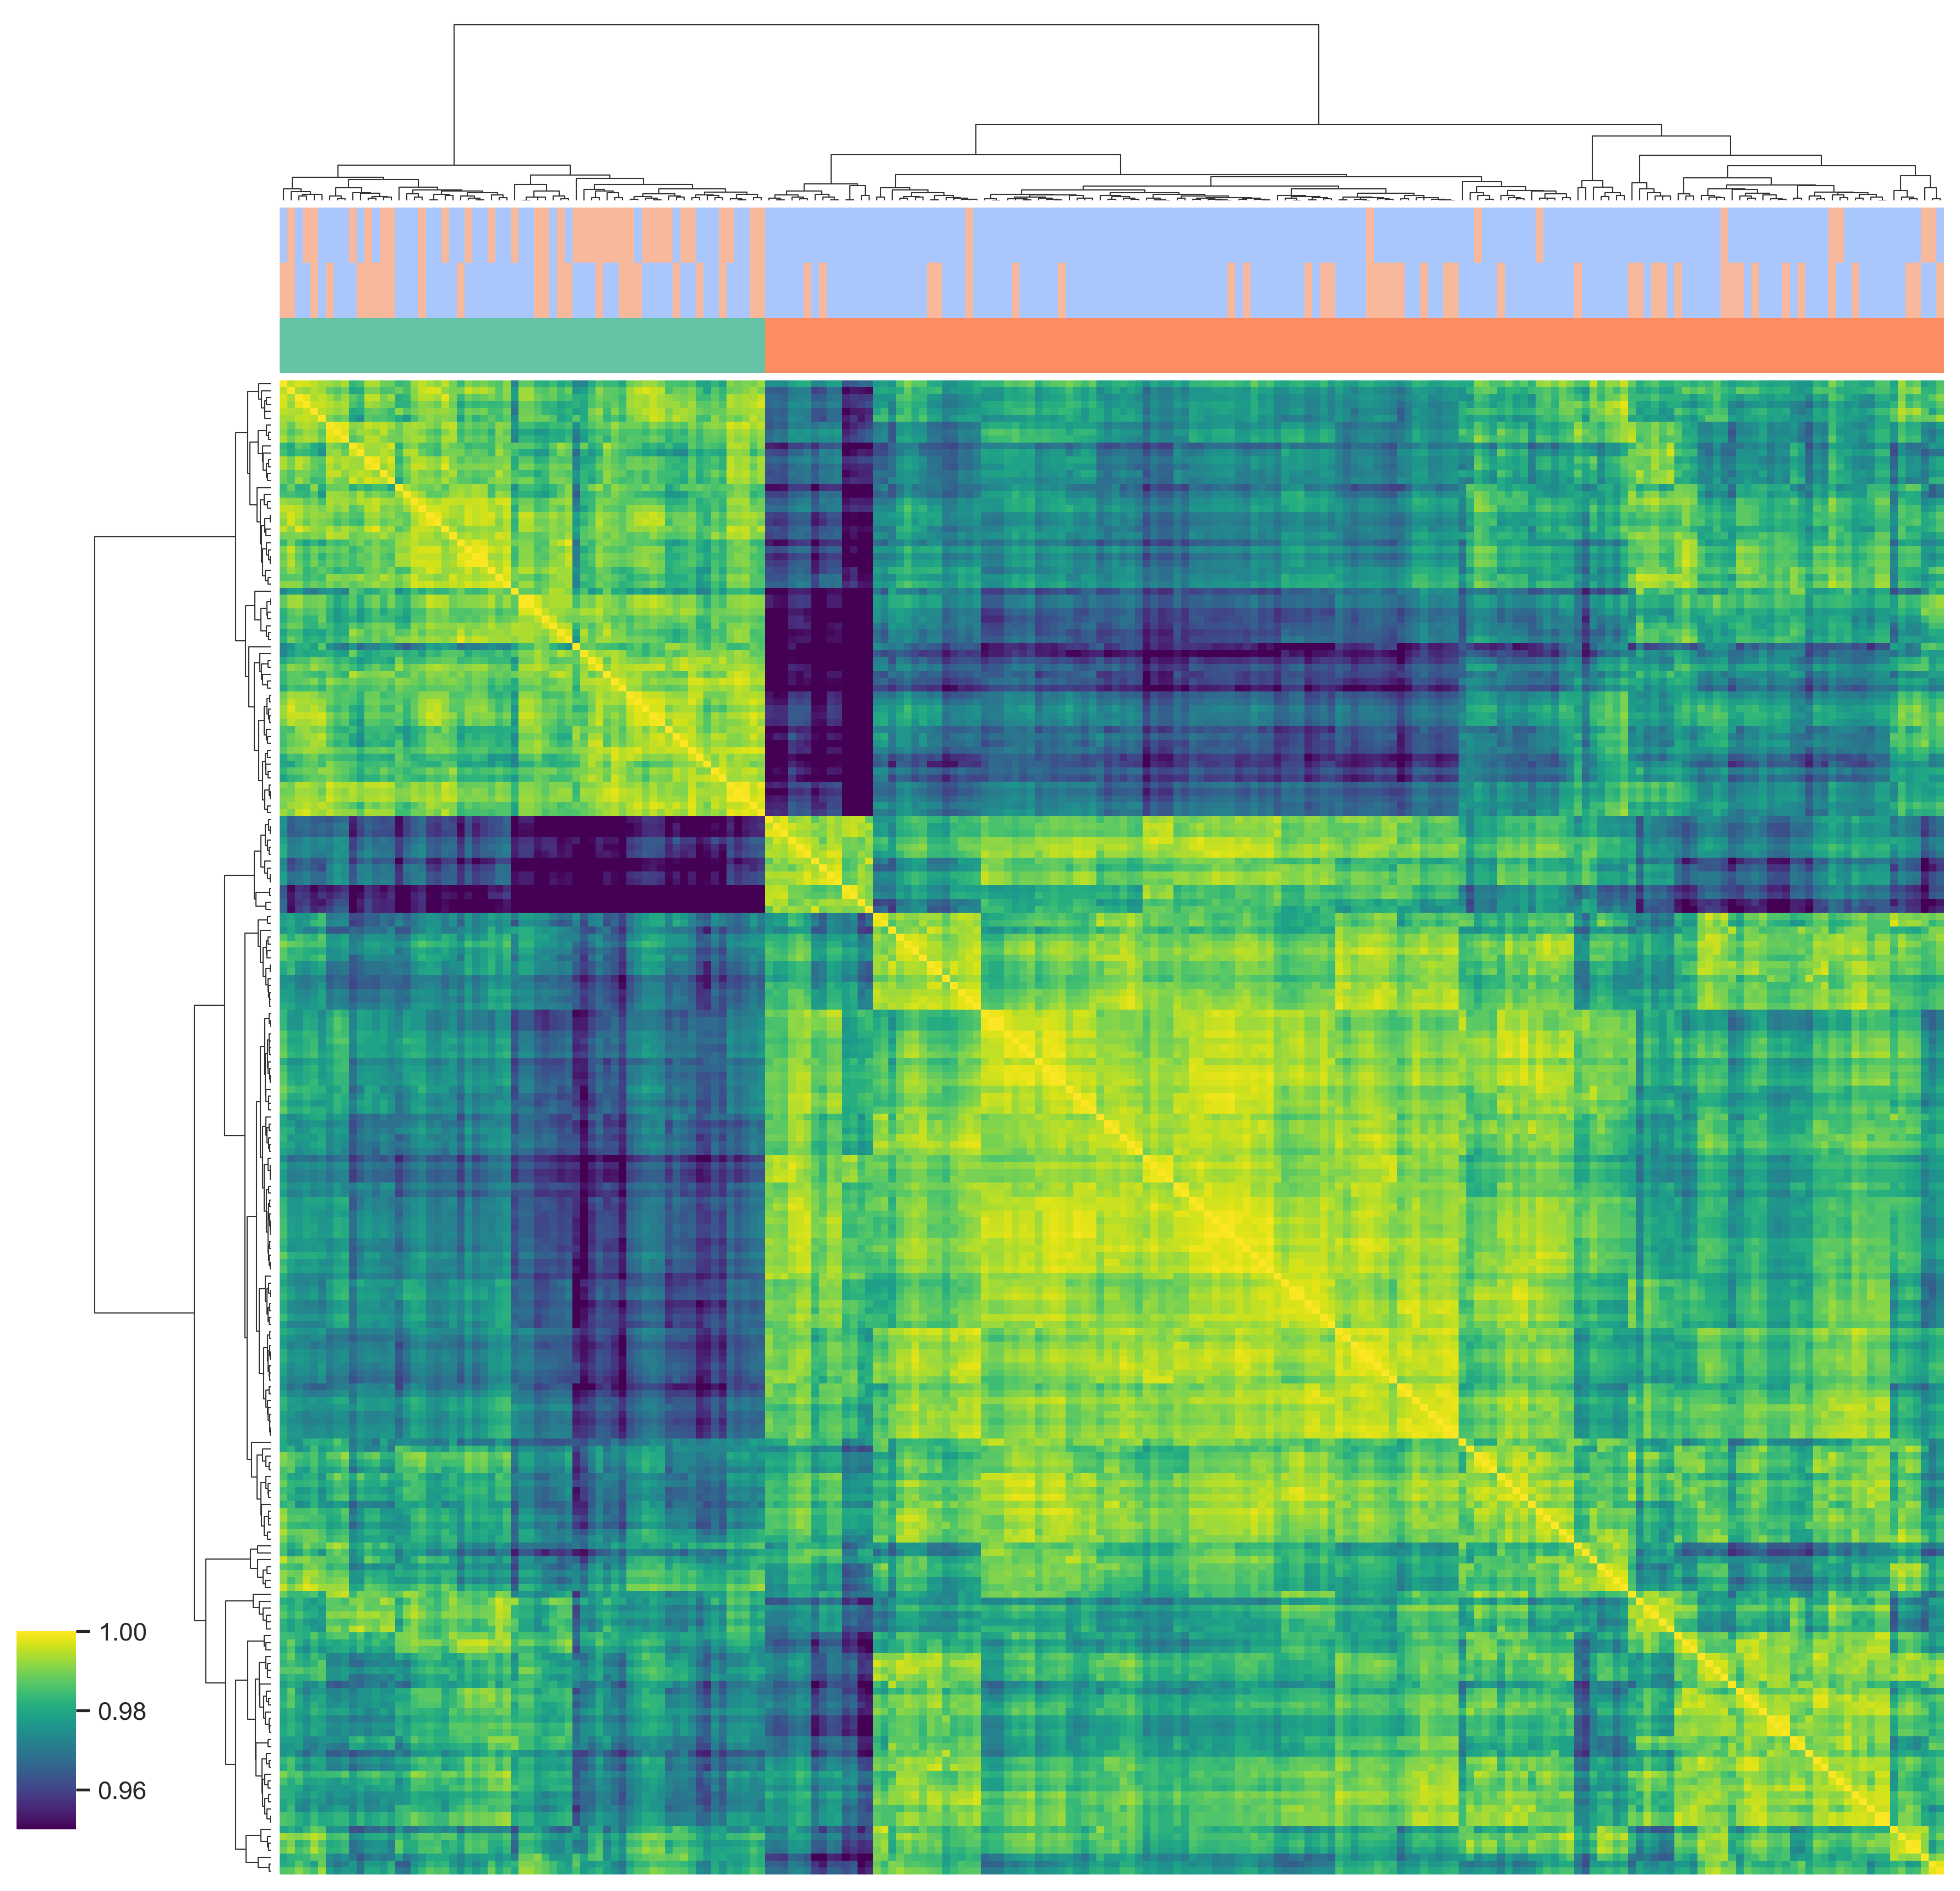

In [49]:
sns.set(style='white', font_scale=2)

trial_name = '1A5'
fold = 1

dfp = pd.read_csv(f'../data/meta/chivos_fragfrax_final.csv', index_col=0)
dfp['RADIUS_BV_TV'] = dfp['RADIUS_BV/TV']
dfp['TIBIA_BV_TV'] = dfp['TIBIA_BV/TV']
# dfp['OP'] = ['Yes' if x==5 else 'No' if x==0 else 0 for x in dfp['label']]
# dfp['Fracture'] = ['Yes' if x==1 else 'No' if x==0 else 0 for x in dfp['fragility_fracture']]


_X = dfp[pqct_params]
df_corr = _X.T.corr(method='spearman')

labels1 = dfp['Label_OP']
lut1 = dict(zip(set(labels1), sns.color_palette('coolwarm',2)), alpha=.1)
col_colors1 = pd.DataFrame(labels1).iloc[:,0].map(lut1)

labels2 = dfp['fragility_fracture']
lut2 = dict(zip(set(labels2), sns.color_palette('coolwarm',2)), alpha=1)
col_colors2 = pd.DataFrame(labels2).iloc[:,0].map(lut2)


sns.set(style='white', font_scale=1)

row_linkage = linkage(df_corr, method='average', metric='cosine')

# 2 clusters
cluster_assignments = fcluster(row_linkage, t=2, criterion='maxclust')
dfp['cluster'] = cluster_assignments
dfp.to_csv('../data/cluster/2cluster.csv')

labels3 = cluster_assignments
lut3 = dict(zip(set(labels3), sns.color_palette('Set2',13)))
col_colors3 = pd.DataFrame(labels3).iloc[:,0].map(lut3)

g = sns.clustermap(df_corr, figsize=(12,12), 
                   method='average', metric='cosine',
                   col_colors=[col_colors1, col_colors2, col_colors3],
                   vmin=.95, vmax=1,
                   cmap='viridis', dendrogram_ratio=(.1,.1))


g.ax_heatmap.set_xticklabels([]);g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticklabels([]);g.ax_heatmap.set_yticks([])

cbar = g.cax
x0,y0,x1,y1 = np.array(g.ax_heatmap.get_position()).flatten()
cbar.set_position([-0.02, 0.07, 0.03, 0.1])

# DL

## Score

In [40]:
# 1A5 model, logistic, Basic+PQCT-DL

history = {}

k = 6
dim = 128
seed = 2023
splits=KFold(n_splits=k,shuffle=True,random_state=seed)

trial_name = '1A5'
label_name = 'fragility_fracture'
method = 'logistic'
sel_col = 'Basic+PQCT-DL'

pqct_params = pqctparams_keys['tibia_fibula'] if trial_name in ['1A1','1A2', '2A1','2A2'] \
        else pqctparams_keys['raidus_ulna'] if trial_name in ['1A3','1A4', '2A3','2A4'] \
        else pqctparams_keys['four_bones']


col_keys = {

'Basic+PQCT-DL':['sex','age','height','weight']+[f'v{i}' for i in range(128)],

}

for fold in range(1,7):

    indices_dict = pkl.load(open(f'../data/meta/indices_{trial_name}.pkl', 'rb'))
    meta_recoded = indices_dict['recoded_meta']
    test_indices = indices_dict['test_indices']
    train_indices = indices_dict[f'train_indices_noaug_fold{fold}']

    df = pd.read_csv(f'../data/embeds/{trial_name}_fold{fold}_dim{dim}.csv', index_col=0)
    df['ptid'] = df['ptid'].astype(int)
    df = pd.merge(df, meta[['ptid','sex','age','height','weight']+pqct_params+bmd_params], on='ptid')
    assert_frame_equal(df[['ptid']], meta_recoded[['ptid']])

    indices_dict[f'embeddings_{fold}'] = df


    sel_colnames = col_keys[sel_col]
    df_train = df.iloc[train_indices,:]

    train_X = df_train.loc[:,sel_colnames].values # [N, 256]
    train_Y = df_train[label_name].values

    clf = LogisticRegression(random_state=seed, multi_class='multinomial').fit(train_X, train_Y) # shuffle data by random_state

    clf.fit(train_X, train_Y)

    df_test = df.copy() # all of them

    test_X = df_test.loc[:,sel_colnames].values
    test_Y = df_test[label_name].values

    pred_probs = clf.predict_proba(test_X)
    
    meta_recoded['score_prob'] = pred_probs[:,1]

    history[fold] = meta_recoded

history

{1:      Unnamed: 0  ptid  label  sex   age  height  weight  RADIUS_Tt_Ar  \
 0             0  1472      5    1  0.54  1.5400   5.900         2.282   
 1             1  1484      5    1  0.58  1.6030   4.900         2.232   
 2             2  1473      0    1  0.54  1.4500   5.400         1.702   
 3             3  1475      0    1  0.55  1.5600   5.300         2.334   
 4             4  1476      0    1  0.51  1.6500   5.100         2.112   
 ..          ...   ...    ...  ...   ...     ...     ...           ...   
 211         211  1891      0    1  0.79  1.5300   5.300         2.894   
 212         212  1901      5    1  0.83  1.5350   6.000         3.030   
 213         213  1903      5    1  0.82  1.4010   7.200         2.060   
 214         214  1902      5    1  0.82  1.5075   5.850         2.341   
 215         215  1904      5    1  0.81  1.5545   6.525         3.384   
 
      RADIUS_Tt_vBMD  RADIUS_Tb_Ar  ...  L1_L4_T  Neck_T  Total_T  \
 0             2.696         1.722  ..

In [41]:
pkl.dump(history, open(f'../data/performance/prob_score.pkl','wb'))

In [5]:
cluster = pd.read_csv('../data/cluster/2cluster.csv', index_col=0)
cluster

ptid  label  sex  age  height  weight  RADIUS_Tt_Ar  RADIUS_Tt_vBMD  \
0    1472      5    1   54  154.00   59.00         228.2           269.6   
1    1484      5    1   58  160.30   49.00         223.2           248.6   
2    1473      0    1   54  145.00   54.00         170.2           362.1   
3    1475      0    1   55  156.00   53.00         233.4           310.3   
4    1476      0    1   51  165.00   51.00         211.2           312.5   
..    ...    ...  ...  ...     ...     ...           ...             ...   
211  1891      0    1   79  153.00   53.00         289.4           201.3   
212  1901      5    1   83  153.50   60.00         303.0           151.2   
213  1903      5    1   82  140.10   72.00         206.0           212.5   
214  1902      5    1   82  150.75   58.50         234.1           125.2   
215  1904      5    1   81  155.45   65.25         338.4           165.2   

     RADIUS_Tb_Ar  RADIUS_Tb_vBMD  ...  FractureHistory  Source  ChivosID  \
0           172.2            40.9  ...                0  Chivos      2001   
1           177.8            86.7  ...                0  Chivos      2001   
2           121.2           129.8  ...                0  Chivos      2002   
3           174.3            90.1  ...                0  Chivos      2003   
4           161.2           135.2  ...                0  Chivos      2004   
..            ...             ...  ...              ...     ...       ...   
211         249.5           104.8  ...                0  Chivos      2269   
212         265.1            75.1  ...                1  Chivos      2271   
213         169.1            74.5  ...                1  Chivos      2272   
214         204.1            32.1  ...                1  Chivos      2273   
215         292.1            76.9  ...                1  Chivos      2274   

     Label_fracture  Label_VF  fragility_fracture  Label_OP  RADIUS_BV_TV  \
0                 0         0                   0         1         0.082   
1                 0         0                   0         1         0.128   
2                 0         0                   0         0         0.185   
3                 0         0                   0         0         0.133   
4                 0         0                   0         0         0.198   
..              ...       ...                 ...       ...           ...   
211               0         0                   0         0         0.154   
212               1         1                   1         0         0.113   
213               1         0                   1         1         0.125   
214               1         0                   1         1         0.077   
215               1         1                   1         0         0.117   

     TIBIA_BV_TV  cluster  
0          0.144        1  
1          0.157        2  
2          0.196        2  
3          0.195        2  
4          0.234        2  
..           ...      ...  
211        0.226        2  
212        0.252        2  
213        0.197        2  
214        0.105        1  
215        0.164        2  

[216 rows x 49 columns]

(array([0, 1]), [Text(0, 0, 'Fragility fracture'), Text(1, 0, 'Osteoporosis')])

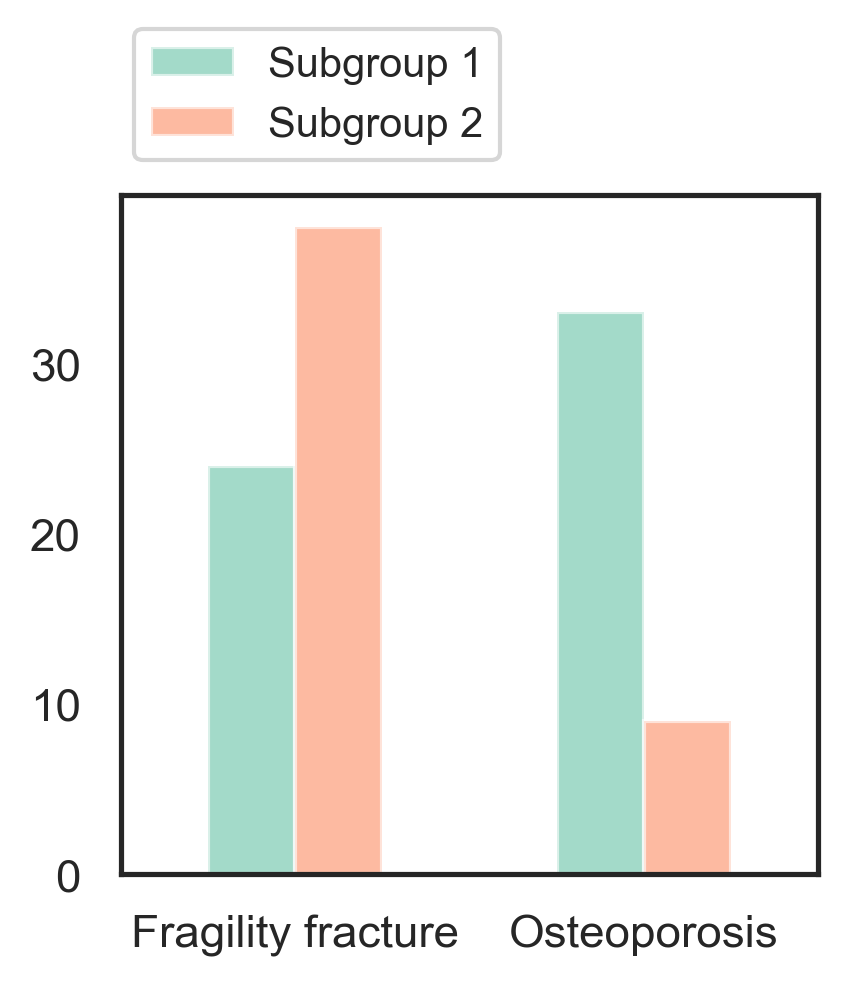

In [11]:
dfp1 = cluster.groupby(['cluster','fragility_fracture']).size().unstack()
dfp2 = cluster.groupby(['cluster','Label_OP']).size().unstack()

sns.set(style='white', font_scale=1)
plt.rcParams['figure.dpi'] = 300

dfp1_renamed = dfp1[[1]].rename(columns={1: 'Fragility fracture'})
dfp2_renamed = dfp2[[1]].rename(columns={1: 'Osteoporosis'})


dfp = dfp1_renamed.join(dfp2_renamed)
dfp.index = ['Subgroup 1','Subgroup 2']

colors = sns.color_palette("Set2", len(dfp.T.columns))

dfp.T.plot(kind='bar', stacked=False, figsize=(3, 3), 
           color=colors,alpha=.6)
plt.legend(title='', loc='lower left', bbox_to_anchor=(-.01,1.02),
           fontsize=10, title_fontsize=10)
# ax.get_legend().remove()
plt.xticks(rotation=0)

In [4]:
with open('../data/performance/prob_score.pkl', 'rb') as f:
    history = pkl.load(f)


In [8]:
dfp = history[1].set_index('Unnamed: 0') # fold1 model pred score (of 1, ie, label fracture)
dfp['RADIUS_BV_TV'] = dfp['RADIUS_BV/TV']
dfp['TIBIA_BV_TV'] = dfp['TIBIA_BV/TV']

dfp = pd.merge(dfp, cluster[['ptid','cluster']])
dfp

ptid  label  sex   age  height  weight  RADIUS_Tt_Ar  RADIUS_Tt_vBMD  \
0    1472      5    1  0.54  1.5400   5.900         2.282           2.696   
1    1484      5    1  0.58  1.6030   4.900         2.232           2.486   
2    1473      0    1  0.54  1.4500   5.400         1.702           3.621   
3    1475      0    1  0.55  1.5600   5.300         2.334           3.103   
4    1476      0    1  0.51  1.6500   5.100         2.112           3.125   
..    ...    ...  ...   ...     ...     ...           ...             ...   
211  1891      0    1  0.79  1.5300   5.300         2.894           2.013   
212  1901      5    1  0.83  1.5350   6.000         3.030           1.512   
213  1903      5    1  0.82  1.4010   7.200         2.060           2.125   
214  1902      5    1  0.82  1.5075   5.850         2.341           1.252   
215  1904      5    1  0.81  1.5545   6.525         3.384           1.652   

     RADIUS_Tb_Ar  RADIUS_Tb_vBMD  ...  FractureHistory  Source  ChivosID  \
0           1.722           0.409  ...                0  Chivos    2001.0   
1           1.778           0.867  ...                0  Chivos    2001.0   
2           1.212           1.298  ...                0  Chivos    2002.0   
3           1.743           0.901  ...                0  Chivos    2003.0   
4           1.612           1.352  ...                0  Chivos    2004.0   
..            ...             ...  ...              ...     ...       ...   
211         2.495           1.048  ...                0  Chivos    2269.0   
212         2.651           0.751  ...                1  Chivos    2271.0   
213         1.691           0.745  ...                1  Chivos    2272.0   
214         2.041           0.321  ...                1  Chivos    2273.0   
215         2.921           0.769  ...                1  Chivos    2274.0   

     Label_fracture  Label_VF  fragility_fracture  score_prob  RADIUS_BV_TV  \
0                 0         0                   0    0.121407         0.082   
1                 0         0                   0    0.154873         0.128   
2                 0         0                   0    0.064596         0.185   
3                 0         0                   0    0.065894         0.133   
4                 0         0                   0    0.077208         0.198   
..              ...       ...                 ...         ...           ...   
211               0         0                   0    0.440917         0.154   
212               1         1                   1    0.625373         0.113   
213               1         0                   1    0.664398         0.125   
214               1         0                   1    0.651008         0.077   
215               1         1                   1    0.419048         0.117   

     TIBIA_BV_TV  cluster  
0          0.144        1  
1          0.157        2  
2          0.196        2  
3          0.195        2  
4          0.234        2  
..           ...      ...  
211        0.226        2  
212        0.252        2  
213        0.197        2  
214        0.105        1  
215        0.164        2  

[216 rows x 49 columns]

In [23]:
name_keys = pd.read_csv('../data/meta/name_keys.csv', index_col=0, squeeze=True)

sel_names2 = [x for x in name_keys.keys()]
print(len(sel_names2))
sel_names2

32


['age',
 'weight',
 'height',
 'L1_L4_T',
 'Neck_T',
 'Total_T',
 'RADIUS_Tt_Ar',
 'RADIUS_Tt_vBMD',
 'RADIUS_Tb_Ar',
 'RADIUS_Tb_vBMD',
 'RADIUS_BV_TV',
 'RADIUS_Tb_N',
 'RADIUS_Tb_Th',
 'RADIUS_Tb_Sp',
 'RADIUS_Ct_Ar',
 'RADIUS_Ct_vBMD',
 'RADIUS_Ct_Pm',
 'RADIUS_Ct_Po',
 'RADIUS_Ct_Th',
 'TIBIA_Tt_Ar',
 'TIBIA_Tt_vBMD',
 'TIBIA_Tb_Ar',
 'TIBIA_Tb_vBMD',
 'TIBIA_BV_TV',
 'TIBIA_Tb_N',
 'TIBIA_Tb_Th',
 'TIBIA_Tb_Sp',
 'TIBIA_Ct_Ar',
 'TIBIA_Ct_vBMD',
 'TIBIA_Ct_Pm',
 'TIBIA_Ct_Po',
 'TIBIA_Ct_Th']

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.522e-05 U_stat=6.619e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.421e-05 U_stat=3.008e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.157e-03 U_stat=3.462e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-0

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.621e-10 U_stat=2.202e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.970e-05 U_stat=3.037e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.885e-01 U_stat=5.180e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-0

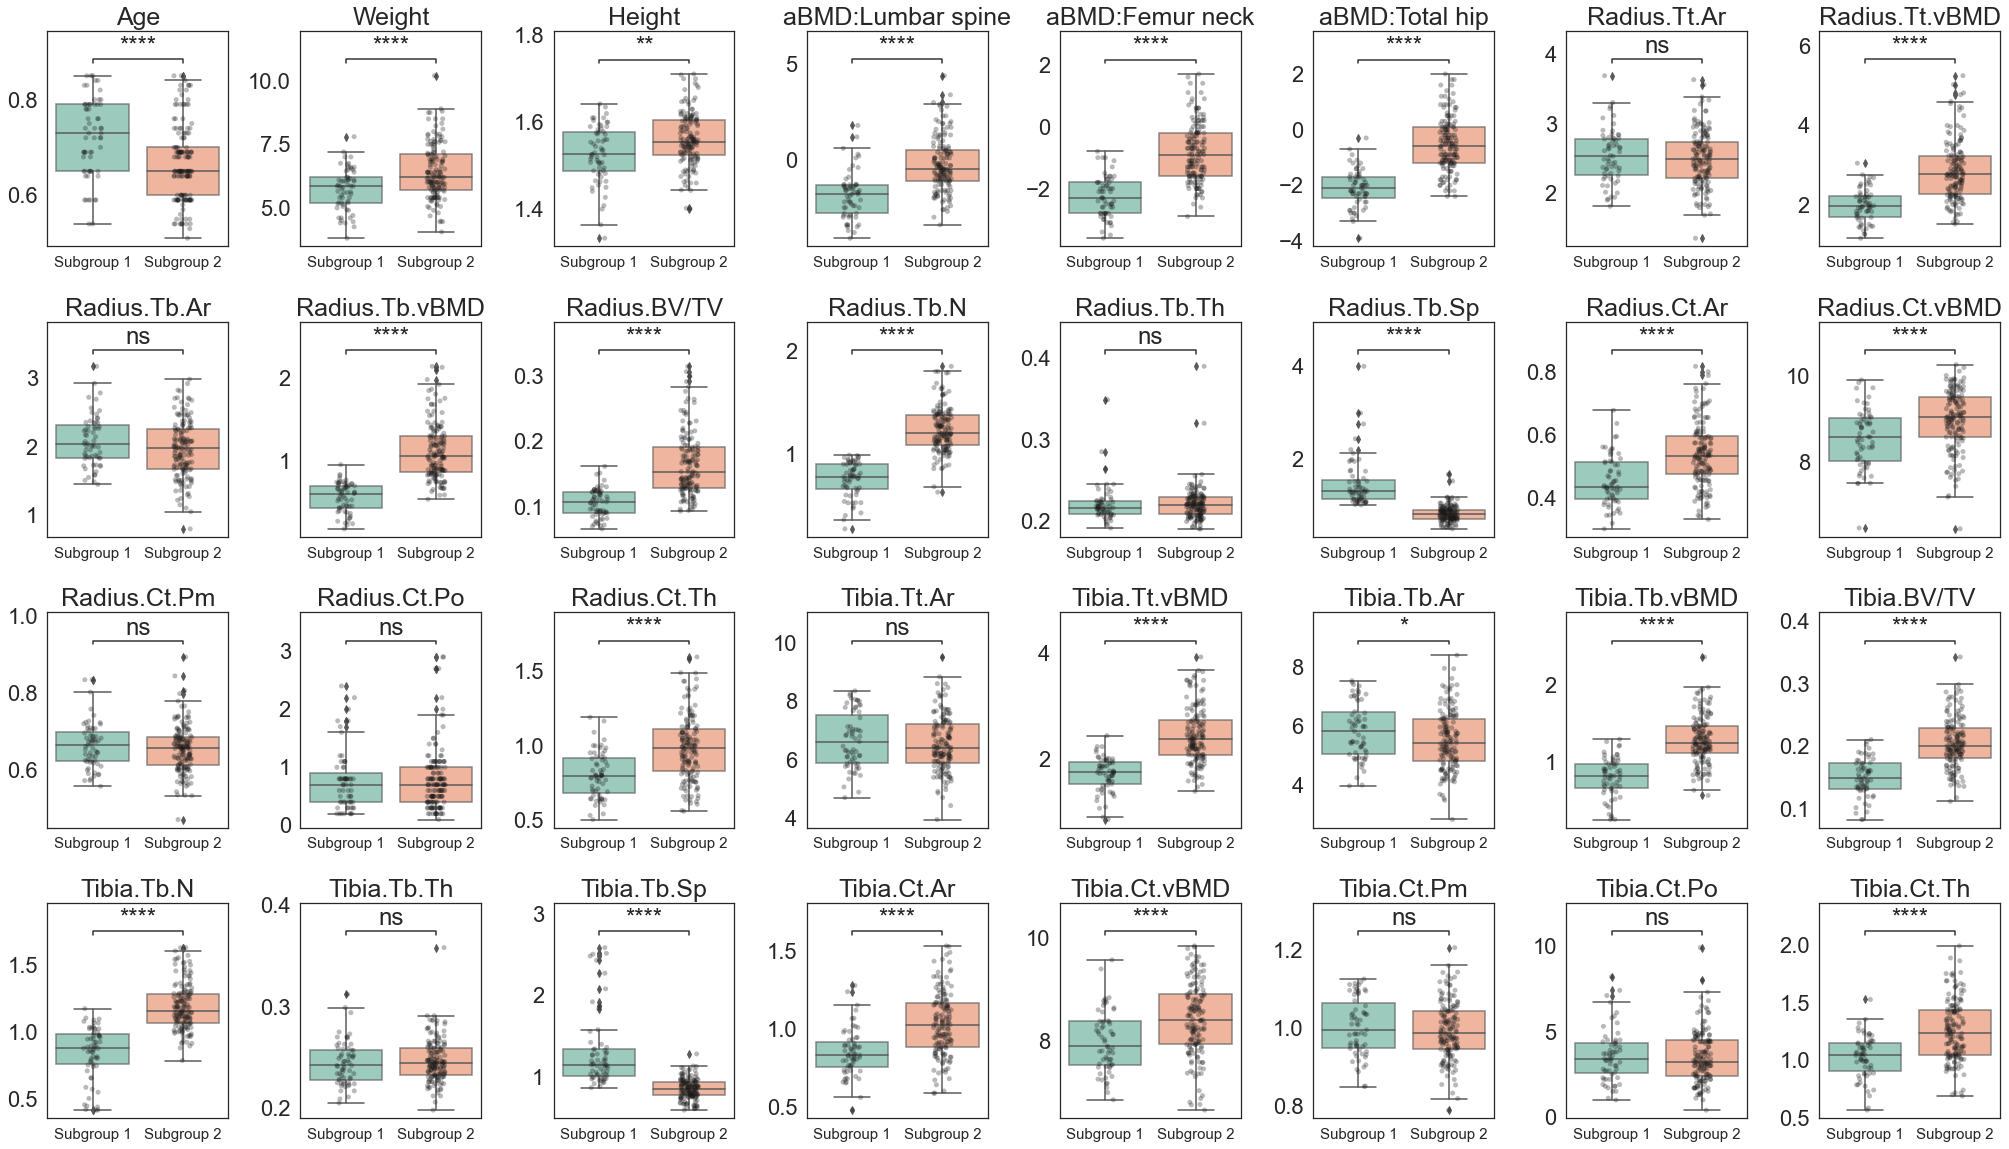

In [24]:
sns.set(style='white', font_scale=2)

fig,axes = plt.subplots(ncols=8,nrows=4, figsize=(35,20))

fig.subplots_adjust(hspace=.35, wspace=.4)

for idx,name in enumerate(sel_names2):
    
    ax = axes.flatten()[idx]
    
    sns.boxplot(data=dfp, x='cluster',y=name, ax=ax, boxprops=dict(alpha=.7), palette='Set2')
    sns.stripplot(data=dfp, x='cluster',y=name, ax=ax, alpha=.3, size=5, jitter=True, color='k')
    ax.set_xlabel(''); ax.set_ylabel('')
    ax.set_title(name_keys[name].replace('BV.TV','BV/TV'), fontsize=25)

    ax.set_xticklabels(['Subgroup 1','Subgroup 2'], fontsize=15) #(ax.get_xticklabels(), rotation = 90)
     
    annotator = Annotator(ax, pairs=[(1,2)], data=dfp, x='cluster', y=name)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction='fdr_bh')
    annotator.apply_and_annotate()

In [20]:
# SELECT those with significant difference between 2 subgroups (including RADIUS_Tb_Ar as it is relevant)
sel_names3 = [
    'age','weight','height',
    'L1_L4_T','Neck_T','Total_T',
    
    'RADIUS_Tt_vBMD','RADIUS_Ct_vBMD','RADIUS_Tb_vBMD',
    'TIBIA_Tt_vBMD','TIBIA_Ct_vBMD','TIBIA_Tb_vBMD',
    
    'RADIUS_Tb_N','TIBIA_Tb_N',
    'RADIUS_Tb_Sp','TIBIA_Tb_Sp',
    'RADIUS_BV_TV','TIBIA_BV_TV',
    
    'RADIUS_Ct_Ar','TIBIA_Ct_Ar',
    'RADIUS_Ct_Th','TIBIA_Ct_Th',
    'RADIUS_Tb_Ar','TIBIA_Tb_Ar'
]

print(len(sel_names3))

24


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.522e-05 U_stat=6.619e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.421e-05 U_stat=3.008e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.157e-03 U_stat=3.462e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-0

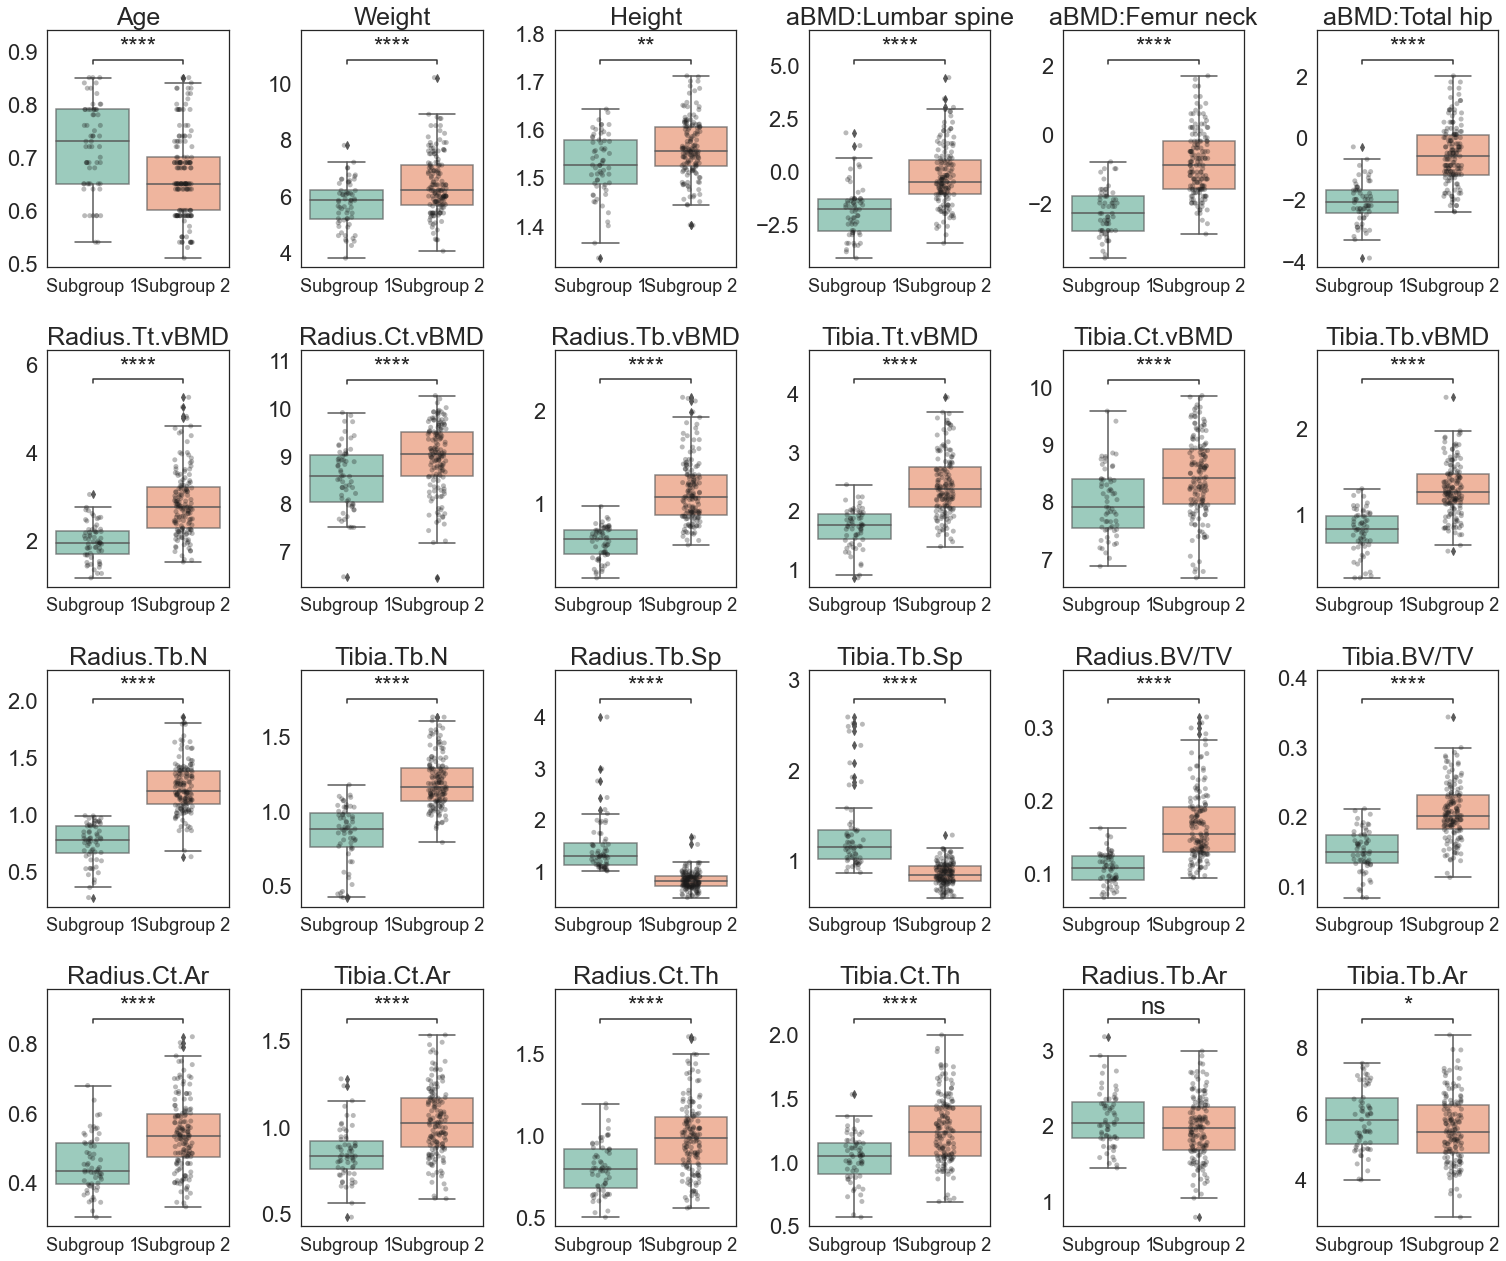

In [26]:
sns.set(style='white', font_scale=2)

fig,axes = plt.subplots(ncols=6,nrows=4, figsize=(26,22))

fig.subplots_adjust(hspace=.35, wspace=.4)

for idx,name in enumerate(sel_names3):
    
    ax = axes.flatten()[idx]
    
    sns.boxplot(data=dfp, x='cluster',y=name, ax=ax, boxprops=dict(alpha=.7), palette='Set2')
    sns.stripplot(data=dfp, x='cluster',y=name, ax=ax, alpha=.3, size=5, jitter=True, color='k')
    ax.set_xlabel(''); ax.set_ylabel('')
    ax.set_title(name_keys[name].replace('BV.TV','BV/TV'), fontsize=25)

    ax.set_xticklabels(['Subgroup 1','Subgroup 2'], fontsize=18) #(ax.get_xticklabels(), rotation = 90)
     
    annotator = Annotator(ax, pairs=[(1,2)], data=dfp, x='cluster', y=name)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction='fdr_bh')
    annotator.apply_and_annotate()
    

# fig.delaxes(axes.flatten()[idx+1]) # eliminate unused subplot


## PCA

In [5]:
acc = pd.read_csv('../data/performance/internal_testset.csv', index_col=0)
acc_sel = acc[(acc['trial']=='1A5') 
              & (acc['model']=='Basic+PQCT-DL(all bones)') 
              & (acc['fusionMethod']=='logistic')
              & (acc['metric']=='f1')]

acc_sel

trial  fold fusionMethod                     model metric  \
1964   1A5     1     logistic  Basic+PQCT-DL(all bones)     f1   
2045   1A5     2     logistic  Basic+PQCT-DL(all bones)     f1   
2126   1A5     3     logistic  Basic+PQCT-DL(all bones)     f1   
2207   1A5     4     logistic  Basic+PQCT-DL(all bones)     f1   
2288   1A5     5     logistic  Basic+PQCT-DL(all bones)     f1   
2369   1A5     6     logistic  Basic+PQCT-DL(all bones)     f1   

                   score bone  
1964  0.6666666666666665  All  
2045  0.6666666666666665  All  
2126                 0.6  All  
2207  0.6666666666666665  All  
2288                 0.5  All  
2369                 0.5  All

In [6]:
meta = pd.read_csv('../data/cluster/2cluster.csv', index_col=0)
cols_sel = ['ptid','age','weight','height',
            'cluster','label','fragility_fracture',
            'tibia_path', 'fibula_path', 'radius_path', 'ulna_path'
            ]
meta_sel = meta[cols_sel]
meta_sel

ptid  age  weight  height  cluster  label  fragility_fracture  \
0    1472   54   59.00  154.00        1      5                   0   
1    1484   58   49.00  160.30        2      5                   0   
2    1473   54   54.00  145.00        2      0                   0   
3    1475   55   53.00  156.00        2      0                   0   
4    1476   51   51.00  165.00        2      0                   0   
..    ...  ...     ...     ...      ...    ...                 ...   
211  1891   79   53.00  153.00        2      0                   0   
212  1901   83   60.00  153.50        2      5                   1   
213  1903   82   72.00  140.10        2      5                   1   
214  1902   82   58.50  150.75        1      5                   1   
215  1904   81   65.25  155.45        2      5                   1   

                                            tibia_path  \
0    /nfs/public/fuwai_PQCT/largebone_npy/00001472/...   
1    /nfs/public/fuwai_PQCT/largebone_npy/00001484/...   
2    /nfs/public/fuwai_PQCT/largebone_npy/00001473/...   
3    /nfs/public/fuwai_PQCT/largebone_npy/00001475/...   
4    /nfs/public/fuwai_PQCT/largebone_npy/00001476/...   
..                                                 ...   
211  /nfs/public/fuwai_PQCT/largebone_npy/00001891/...   
212  /nfs/public/fuwai_PQCT/largebone_npy/00001901/...   
213  /nfs/public/fuwai_PQCT/largebone_npy/00001903/...   
214  /nfs/public/fuwai_PQCT/largebone_npy/00001902/...   
215  /nfs/public/fuwai_PQCT/largebone_npy/00001904/...   

                                           fibula_path  \
0    /nfs/public/fuwai_PQCT/smallbone_npy/00001472/...   
1    /nfs/public/fuwai_PQCT/smallbone_npy/00001484/...   
2    /nfs/public/fuwai_PQCT/smallbone_npy/00001473/...   
3    /nfs/public/fuwai_PQCT/smallbone_npy/00001475/...   
4    /nfs/public/fuwai_PQCT/smallbone_npy/00001476/...   
..                                                 ...   
211  /nfs/public/fuwai_PQCT/smallbone_npy/00001891/...   
212  /nfs/public/fuwai_PQCT/smallbone_npy/00001901/...   
213  /nfs/public/fuwai_PQCT/smallbone_npy/00001903/...   
214  /nfs/public/fuwai_PQCT/smallbone_npy/00001902/...   
215  /nfs/public/fuwai_PQCT/smallbone_npy/00001904/...   

                                           radius_path  \
0    /nfs/public/fuwai_PQCT/largebone_npy/00001472/...   
1    /nfs/public/fuwai_PQCT/largebone_npy/00001484/...   
2    /nfs/public/fuwai_PQCT/largebone_npy/00001473/...   
3    /nfs/public/fuwai_PQCT/largebone_npy/00001475/...   
4    /nfs/public/fuwai_PQCT/largebone_npy/00001476/...   
..                                                 ...   
211  /nfs/public/fuwai_PQCT/largebone_npy/00001891/...   
212  /nfs/public/fuwai_PQCT/largebone_npy/00001901/...   
213  /nfs/public/fuwai_PQCT/largebone_npy/00001903/...   
214  /nfs/public/fuwai_PQCT/largebone_npy/00001902/...   
215  /nfs/public/fuwai_PQCT/largebone_npy/00001904/...   

                                             ulna_path  
0    /nfs/public/fuwai_PQCT/smallbone_npy/00001472/...  
1    /nfs/public/fuwai_PQCT/smallbone_npy/00001484/...  
2    /nfs/public/fuwai_PQCT/smallbone_npy/00001473/...  
3    /nfs/public/fuwai_PQCT/smallbone_npy/00001475/...  
4    /nfs/public/fuwai_PQCT/smallbone_npy/00001476/...  
..                                                 ...  
211  /nfs/public/fuwai_PQCT/smallbone_npy/00001891/...  
212  /nfs/public/fuwai_PQCT/smallbone_npy/00001901/...  
213  /nfs/public/fuwai_PQCT/smallbone_npy/00001903/...  
214  /nfs/public/fuwai_PQCT/smallbone_npy/00001902/...  
215  /nfs/public/fuwai_PQCT/smallbone_npy/00001904/...  

[216 rows x 11 columns]

In [7]:
meta.groupby(['FractureHistory','fragility_fracture','Label_VF']).size().unstack()

Label_VF                                0     1
FractureHistory fragility_fracture             
0               0                   142.0   NaN
1               0                    12.0   NaN
                1                    25.0  37.0

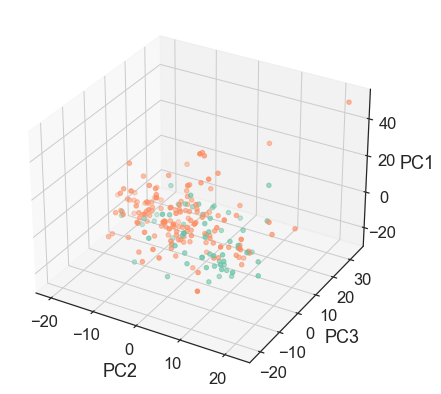

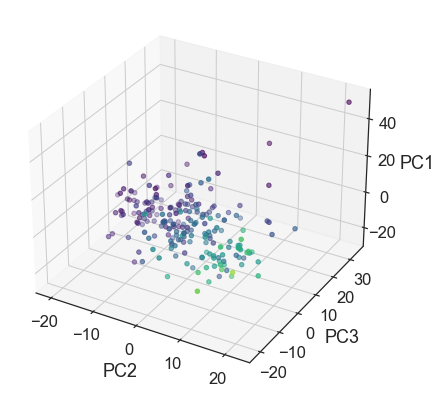

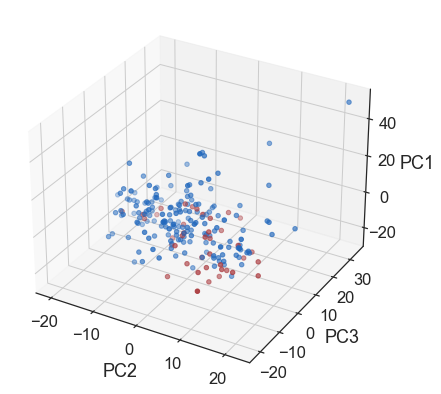

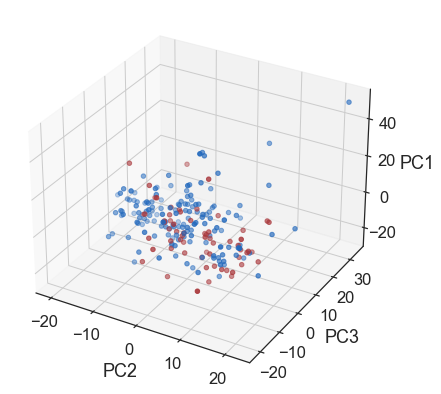

In [8]:
sns.set(style='white', font_scale=1.5)
import matplotlib as mpl
mpl.rcParams['axes.labelpad'] = 10 

trial_name = '1A5'
cols_all = [f'v{x}' for x in range(0,128)] + ['age','weight','height']

scores = pkl.load(open(f'../data/performance/prob_score.pkl', 'rb'))


for fold in [4]:#range(1,7):

    embed = pd.read_csv(f'../data/embeds/1A5_fold{fold}_dim128.csv', index_col=0)[['ptid']+[f'v{x}' for x in range(0,128)]]
    meta_tmp = pd.read_csv('../data/cluster/2cluster.csv', index_col=0)
    score_prob = scores[fold]
    
    dfp = pd.merge(meta_tmp, embed, on='ptid')
    
    labels = dfp['cluster']
    lut = dict(zip(set(labels), sns.color_palette('Set2',13)))
    col_colors = pd.DataFrame(labels).iloc[:,0].map(lut)

    
    _X = dfp[cols_all].values

    pca = decomposition.PCA(n_components=3)
    pca.fit(_X) # sample x dim
    X = pca.transform(_X)

    dfp['PC1'] = X[:,0]
    dfp['PC2'] = X[:,1]
    dfp['PC3'] = X[:,2]
    
    assert np.all(dfp['ptid']==score_prob['ptid']) 
    dfp['score'] = score_prob['score_prob']

#     fig = plt.figure(figsize=(7, 21))

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(dfp['PC2'], dfp['PC3'], dfp['PC1'], c=col_colors)
    ax.set_xlabel('PC2')
    ax.set_ylabel('PC3')
    ax.set_zlabel('PC1')
#     ax.set_title('Cluster', fontsize=30)

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(dfp['PC2'], dfp['PC3'], dfp['PC1'], c=dfp['score'], 
                         cmap='viridis', vmin=0, vmax=1)
    ax.set_xlabel('PC2')
    ax.set_ylabel('PC3')
    ax.set_zlabel('PC1')
#     cbar = fig.colorbar(scatter, ax=ax, shrink=0.3, aspect=10, pad=0.2)  # Adjust 'shrink' as needed
#     cbar.set_label('DL score')

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(dfp['PC2'], dfp['PC3'], dfp['PC1'], c=pd.Categorical(dfp['Label_OP']).codes, cmap='vlag')
    ax.set_xlabel('PC2')
    ax.set_ylabel('PC3')
    ax.set_zlabel('PC1')
#     ax.set_title('Osteoporosis', fontsize=30)

    
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(dfp['PC2'], dfp['PC3'], dfp['PC1'], c=pd.Categorical(dfp['fragility_fracture']).codes, cmap='vlag')
    ax.set_xlabel('PC2')
    ax.set_ylabel('PC3')
    ax.set_zlabel('PC1')
#     ax.set_title('Fracture', fontsize=30)
    
    

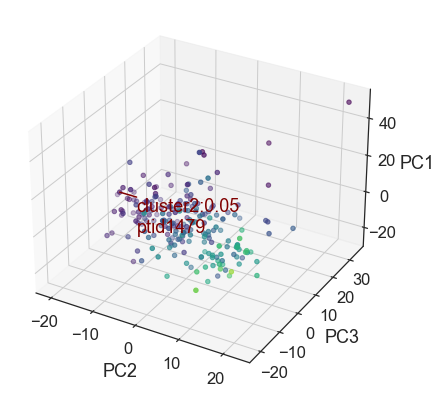

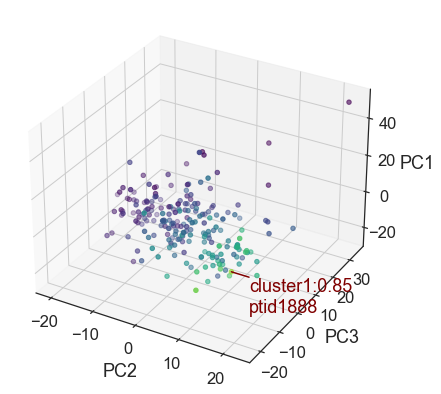

In [15]:
for sel_id in [1479,1888]:
    
    label = meta_sel[meta_sel['ptid']==sel_id]['cluster'].values[0]
    
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(dfp['PC2'], dfp['PC3'], dfp['PC1'], c=dfp['score'], 
                         cmap='viridis', vmin=0, vmax=1)
    ax.set_xlabel('PC2')
    ax.set_ylabel('PC3')
    ax.set_zlabel('PC1')

    def label_point(ax, row, offset=(0, 0, 0)):
        x, y, z, score = row[['PC2', 'PC3', 'PC1', 'score']].values
        ax.text(x + offset[0], y + offset[1], z + offset[2], f'cluster{label}:{score:.2f}\nptid{sel_id}', 
                horizontalalignment='left', verticalalignment='top', color='maroon')
        ax.plot([x, x + offset[0]], [y, y + offset[1]], [z, z + offset[2]], color='maroon')

    # Label points with ptid 1903 (0.85) and 1710 (0.1)
    for ptid in [sel_id]:
        row = dfp[dfp['ptid'] == ptid]
        if not row.empty:
            label_point(ax, row.iloc[0], offset=(4, 0, 0))  # Adjust the offset as needed

    plt.show()

    

Text(0, 0.5, 'Number')

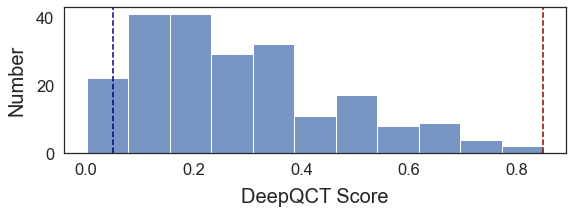

In [18]:
fig,ax = plt.subplots(figsize=(9,2.7))

ax.axvline(x=0.05,ls='--',color='navy')
ax.axvline(x=0.85,ls='--',color='maroon')

sns.histplot(dfp['score'], ax=ax)
ax.set_xlabel('DeepQCT Score', fontsize=20)
ax.set_ylabel('Number', fontsize=20)

## Images

In [19]:
meta = pd.read_csv('../data/cluster/2cluster.csv', index_col=0)
cols_sel = ['ptid','age','weight','height',
            'cluster','label','fragility_fracture',
            'tibia_path', 'fibula_path', 'radius_path', 'ulna_path'
            ]
meta_sel = meta[cols_sel]
meta_sel

ptid  age  weight  height  cluster  label  fragility_fracture  \
0    1472   54   59.00  154.00        1      5                   0   
1    1484   58   49.00  160.30        2      5                   0   
2    1473   54   54.00  145.00        2      0                   0   
3    1475   55   53.00  156.00        2      0                   0   
4    1476   51   51.00  165.00        2      0                   0   
..    ...  ...     ...     ...      ...    ...                 ...   
211  1891   79   53.00  153.00        2      0                   0   
212  1901   83   60.00  153.50        2      5                   1   
213  1903   82   72.00  140.10        2      5                   1   
214  1902   82   58.50  150.75        1      5                   1   
215  1904   81   65.25  155.45        2      5                   1   

                                            tibia_path  \
0    /nfs/public/fuwai_PQCT/largebone_npy/00001472/...   
1    /nfs/public/fuwai_PQCT/largebone_npy/00001484/...   
2    /nfs/public/fuwai_PQCT/largebone_npy/00001473/...   
3    /nfs/public/fuwai_PQCT/largebone_npy/00001475/...   
4    /nfs/public/fuwai_PQCT/largebone_npy/00001476/...   
..                                                 ...   
211  /nfs/public/fuwai_PQCT/largebone_npy/00001891/...   
212  /nfs/public/fuwai_PQCT/largebone_npy/00001901/...   
213  /nfs/public/fuwai_PQCT/largebone_npy/00001903/...   
214  /nfs/public/fuwai_PQCT/largebone_npy/00001902/...   
215  /nfs/public/fuwai_PQCT/largebone_npy/00001904/...   

                                           fibula_path  \
0    /nfs/public/fuwai_PQCT/smallbone_npy/00001472/...   
1    /nfs/public/fuwai_PQCT/smallbone_npy/00001484/...   
2    /nfs/public/fuwai_PQCT/smallbone_npy/00001473/...   
3    /nfs/public/fuwai_PQCT/smallbone_npy/00001475/...   
4    /nfs/public/fuwai_PQCT/smallbone_npy/00001476/...   
..                                                 ...   
211  /nfs/public/fuwai_PQCT/smallbone_npy/00001891/...   
212  /nfs/public/fuwai_PQCT/smallbone_npy/00001901/...   
213  /nfs/public/fuwai_PQCT/smallbone_npy/00001903/...   
214  /nfs/public/fuwai_PQCT/smallbone_npy/00001902/...   
215  /nfs/public/fuwai_PQCT/smallbone_npy/00001904/...   

                                           radius_path  \
0    /nfs/public/fuwai_PQCT/largebone_npy/00001472/...   
1    /nfs/public/fuwai_PQCT/largebone_npy/00001484/...   
2    /nfs/public/fuwai_PQCT/largebone_npy/00001473/...   
3    /nfs/public/fuwai_PQCT/largebone_npy/00001475/...   
4    /nfs/public/fuwai_PQCT/largebone_npy/00001476/...   
..                                                 ...   
211  /nfs/public/fuwai_PQCT/largebone_npy/00001891/...   
212  /nfs/public/fuwai_PQCT/largebone_npy/00001901/...   
213  /nfs/public/fuwai_PQCT/largebone_npy/00001903/...   
214  /nfs/public/fuwai_PQCT/largebone_npy/00001902/...   
215  /nfs/public/fuwai_PQCT/largebone_npy/00001904/...   

                                             ulna_path  
0    /nfs/public/fuwai_PQCT/smallbone_npy/00001472/...  
1    /nfs/public/fuwai_PQCT/smallbone_npy/00001484/...  
2    /nfs/public/fuwai_PQCT/smallbone_npy/00001473/...  
3    /nfs/public/fuwai_PQCT/smallbone_npy/00001475/...  
4    /nfs/public/fuwai_PQCT/smallbone_npy/00001476/...  
..                                                 ...  
211  /nfs/public/fuwai_PQCT/smallbone_npy/00001891/...  
212  /nfs/public/fuwai_PQCT/smallbone_npy/00001901/...  
213  /nfs/public/fuwai_PQCT/smallbone_npy/00001903/...  
214  /nfs/public/fuwai_PQCT/smallbone_npy/00001902/...  
215  /nfs/public/fuwai_PQCT/smallbone_npy/00001904/...  

[216 rows x 11 columns]

(452, 532)
(255, 208)
(376, 261)
(276, 251)
(517, 524)
(269, 182)
(398, 258)
(193, 172)


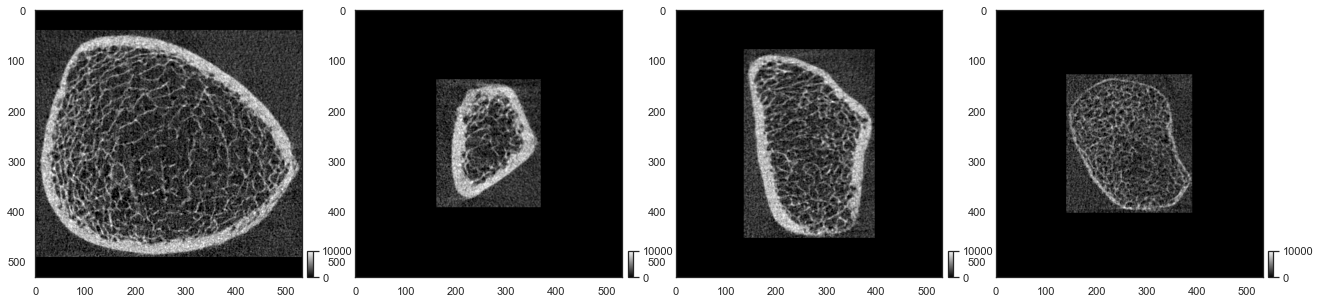

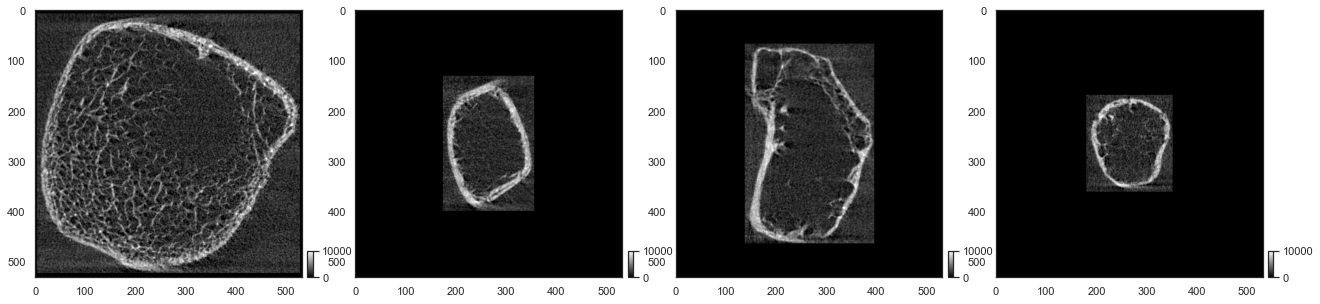

In [20]:
sns.set(font_scale=1)
sns.set_style('white')

desired_size = 532 # max of all sel img

from mpl_toolkits.axes_grid1 import make_axes_locatable

id_plots = [1479,1888] # high score-cluster1(also OP+Frax+), low score-cluster2(also OP-Frax-)
    
for ptid in id_plots:
    
    tmp = meta_sel[meta_sel['ptid']==ptid]
        
    fpath1,fpath2,fpath3,fpath4 = tmp[['tibia_path','fibula_path','radius_path','ulna_path']].values[0]
    ptid,cluster,op,frax = tmp[['ptid','cluster','label','fragility_fracture']].values[0]
    op = 'Y' if op==5 else 'N'; frax='Y' if frax==1 else 'N'

    fig,axes = plt.subplots(1,4,figsize=(22,5)); axes = axes.flatten()

    for idx,fpath in enumerate([fpath1,fpath2,fpath3,fpath4]):

        ax = axes[idx]
        
        original_image = np.load(fpath)
        print(original_image.shape)

        # Determine the size of the padding
        
        original_size = original_image.shape
        delta_width = desired_size - original_size[1]
        delta_height = desired_size - original_size[0]
        left_pad = delta_width // 2
        top_pad = delta_height // 2

        # Create a new array filled with zeros (black) with the desired size
        padded_image = np.zeros((desired_size, desired_size), dtype=original_image.dtype)

        # Place the original image in the center of the new array
        padded_image[top_pad:top_pad+original_size[0], left_pad:left_pad+original_size[1]] = original_image

        # Plot the padded image
        im = ax.imshow(padded_image, cmap='gray', vmin=0, vmax=10000)

        # Optionally, hide axes
#         ax.axis('off')
#         ax.set_title(f'Cluster{cluster} OP-{op} Frax-{frax} (ID{ptid})')

        bounds = ax.get_position().bounds
        left, bottom, width, height = bounds
        colorbar_width = width * 0.02  # Set colorbar width as a fraction of the plot width
        colorbar_height = height * 0.1  # Set colorbar height as a fraction of the plot height
        colorbar_left = left + width + colorbar_width * 1  # Position colorbar to the right with some padding
        colorbar_bottom = bottom  # Align colorbar bottom with plot bottom

        # Create a new axes for the colorbar
        cax = fig.add_axes([colorbar_left, colorbar_bottom, colorbar_width, colorbar_height])

        # Add colorbar to the new axes
        fig.colorbar(im, cax=cax, orientation='vertical')
